In [1]:
%cd /home/jnainani_umass_edu/codellm/MechInterpCodeLLMs

/home/jnainani_umass_edu/codellm/MechInterpCodeLLMs


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.stats import linregress
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
import os
import time
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from torchtyping import TensorType as TT
from typing import List, Union, Optional, Callable
from typing_extensions import Literal
from functools import partial
import copy
import itertools
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

# THIS IS A LOCAL (MODIFIED) VERSION OF TRANSFORMER_LENS - UNINSTALL PIP/CONDA VERSION BEFORE USE!
import transformer_lens
import transformer_lens.utils as utils
import transformer_lens.patching as patching
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import (
    HookedTransformer,
    HookedTransformerConfig,
    FactoredMatrix,
    ActivationCache,
)

import os
from config import HF_TOKEN, HF_PATH

os.environ["HF_TOKEN"] = HF_TOKEN
os.environ["TRANSFORMERS_CACHE"] = HF_PATH
os.environ["HF_DATASETS_CACHE"] = HF_PATH
os.environ["HF_HOME"] = HF_PATH

# When using multiple GPUs we use GPU 0 as the primary and switch to the next when it is 90% full
num_gpus = torch.cuda.device_count()
device_id = 0
if num_gpus > 0:
    device = "cuda:0"
else:
    device = "cpu"
    
def check_gpu_memory(max_alloc=0.9):
    if not torch.cuda.is_available():
        return
    global device_id, device
    print("Primary device:", device)
    torch.cuda.empty_cache()
    max_alloc = 1 if max_alloc > 1 else max_alloc
    for gpu in range(num_gpus):
        memory_reserved = torch.cuda.memory_reserved(device=gpu)
        memory_allocated = torch.cuda.memory_allocated(device=gpu)
        total_memory = torch.cuda.get_device_properties(gpu).total_memory 
        print(f"GPU {gpu}: {total_memory / (1024**2):.2f} MB  Allocated: {memory_allocated / (1024**2):.2f} MB  Reserved: {memory_reserved / (1024**2):.2f} MB")
                
        # Check if the current GPU is getting too full, and if so we switch the primary device to the next GPU
        if memory_reserved > max_alloc * total_memory:
            if device_id < num_gpus - 1:
                device_id += 1
                device = f"cuda:{device_id}"
                print(f"Switching primary device to {device}")
            else:
                print("Cannot switch primary device, all GPUs are nearly full")

print("Number of GPUs:", num_gpus)
check_gpu_memory()

def timeit(func):
    """Decorator to measure the execution time of a function."""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function {func.__name__!r} executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

# Create transformer
model = HookedTransformer.from_pretrained("CodeLlama-7b-hf", n_devices=num_gpus)

# We need these so that individual attention heads and MLP inputs can be edited
model.set_use_attn_in(True)
model.set_use_hook_mlp_in(True)
model.set_use_attn_result(True) # Documentation says this easily burns through GPU memory

check_gpu_memory()

Number of GPUs: 1
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 0.00 MB  Reserved: 0.00 MB


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model CodeLlama-7b-hf into HookedTransformer
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26348.48 MB  Reserved: 26370.00 MB


In [3]:
with open('data/info_retrieval/instructed_trial3.json', 'r') as f:
    data = json.load(f)

# Take the first few dictionaries (e.g., first 3)
subset = data[:190]

# Initialize lists
prompts = []
answers = []

# Extract prompts and outputs
outputs = []
for ind, item in enumerate(subset):
    # if ind in [0, 1, 3, 4, 5, 6, 7, 9]:
    # print(()
    if model.to_tokens(item["prompt"]).shape[-1] == 40:
        prompts.append(item["prompt"])
        outputs.append(item["output"])

# Group pairs of outputs and reverse the tuples alternately
for i in range(0, len(outputs) - 1, 2):
    answers.append((outputs[i], outputs[i + 1]))
    answers.append((outputs[i + 1], outputs[i]))

# Display the results
print("Prompts:", prompts)
print("Answers:", answers)
print("Prompts:", len(prompts))
print("Answers:", len(answers))

clean_tokens = model.to_tokens(prompts)
# Swap each adjacent pair, with a hacky list comprehension
corrupted_tokens = clean_tokens[
    [(i+1 if i%2==0 else i-1) for i in range(len(clean_tokens)) ]
    ]
print("Clean string 0", model.to_string(clean_tokens[0]))
print("Corrupted string 0", model.to_string(corrupted_tokens[0]))
check_gpu_memory()

answer_token_indices = torch.tensor([[model.to_single_token(answers[i][j]) for j in range(2)] for i in range(len(answers))], device=device)
print("Answer token indices", answer_token_indices)
check_gpu_memory()

Prompts: [" D = 'rose'  J = 'document'  A = 'ring'  E = 'cup'  The name of the key that has the value 'rose' is ", " D = 'rose'  J = 'document'  A = 'ring'  E = 'cup'  The name of the key that has the value 'document' is ", " D = 'rose'  J = 'document'  A = 'ring'  E = 'cup'  The name of the key that has the value 'ring' is ", " D = 'rose'  J = 'document'  A = 'ring'  E = 'cup'  The name of the key that has the value 'cup' is ", " H = 'clock'  G = 'disk'  J = 'hat'  E = 'key'  The name of the key that has the value 'clock' is ", " H = 'clock'  G = 'disk'  J = 'hat'  E = 'key'  The name of the key that has the value 'disk' is ", " H = 'clock'  G = 'disk'  J = 'hat'  E = 'key'  The name of the key that has the value 'hat' is ", " H = 'clock'  G = 'disk'  J = 'hat'  E = 'key'  The name of the key that has the value 'key' is ", " K = 'sheet'  B = 'bell'  F = 'game'  D = 'boot'  The name of the key that has the value 'sheet' is ", " K = 'sheet'  B = 'bell'  F = 'game'  D = 'boot'  The name 

In [4]:
# Logit difference metric
def get_logit_diff(logits, answer_token_indices=answer_token_indices, device="cpu"):
    if len(logits.shape) == 3:
        # Get final logits only
        logits = logits[:, -1, :]
    logits = logits.to(answer_token_indices.device)
    correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
    incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
    return (correct_logits - incorrect_logits).mean()

@timeit
def get_cache_fwd_and_bwd(model, tokens, metric, answer_indices):
    model.reset_hooks()
    cache = {}

    def forward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, forward_cache_hook, "fwd")
    grad_cache = {}

    def backward_cache_hook(act, hook):
        act = act.to(device)
        torch.cuda.empty_cache()
        grad_cache[hook.name] = act

    model.add_hook(filter_not_qkv_input, backward_cache_hook, "bwd")
    
    result = model(tokens).to(device)
    torch.cuda.empty_cache()
    value = metric(result, answer_indices)
    value.backward()

    # Reset hooks and clear unused GPU memory
    value = value.item()
    model.reset_hooks()
    torch.cuda.empty_cache()
    
    cache = ActivationCache(cache, model).to(device)
    grad_cache = ActivationCache(grad_cache, model).to(device)
    
    return value, cache, grad_cache

@timeit
def create_attention_attr(
    clean_cache, clean_grad_cache, device
) -> TT["batch", "layer", "head_index", "dest", "src"]:
    attention_stack = torch.stack(
        [clean_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_grad_stack = torch.stack(
        [clean_grad_cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    attention_attr = attention_grad_stack * attention_stack
    attention_attr = einops.rearrange(
        attention_attr,
        "layer batch head_index dest src -> batch layer head_index dest src",
    )
    return attention_attr

@timeit
def attr_patch_residual(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device,
) -> TT["component", "pos"]:
    clean_residual, residual_labels = clean_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=True
    )
    corrupted_residual = corrupted_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    corrupted_grad_residual = corrupted_grad_cache.accumulated_resid(
        -1, incl_mid=True, return_labels=False
    )
    residual_attr = einops.reduce(
        corrupted_grad_residual * (clean_residual - corrupted_residual),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return residual_attr, residual_labels

@timeit
def attr_patch_layer_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    clean_layer_out, labels = clean_cache.decompose_resid(-1, return_labels=True)
    corrupted_layer_out = corrupted_cache.decompose_resid(-1, return_labels=False)
    corrupted_grad_layer_out = corrupted_grad_cache.decompose_resid(
        -1, return_labels=False
    )
    layer_out_attr = einops.reduce(
        corrupted_grad_layer_out * (clean_layer_out - corrupted_layer_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return layer_out_attr, labels

@timeit
def attr_patch_head_out(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_out = clean_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_head_out = corrupted_cache.stack_head_results(-1, return_labels=False).to(device)
    corrupted_grad_head_out = corrupted_grad_cache.stack_head_results(
        -1, return_labels=False
    ).to(device)
    head_out_attr = einops.reduce(
        corrupted_grad_head_out * (clean_head_out - corrupted_head_out),
        "component batch pos d_model -> component pos",
        "sum",
    ).to(device)
    return head_out_attr, labels

def stack_head_vector_from_cache(
    cache, activation_name: Literal["q", "k", "v", "z"], device
) -> TT["layer_and_head_index", "batch", "pos", "d_head"]:
    """Stacks the head vectors from the cache from a specific activation (key, query, value or mixed_value (z)) into a single tensor."""
    stacked_head_vectors = torch.stack(
        [cache[activation_name, l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_vectors = einops.rearrange(
        stacked_head_vectors,
        "layer batch pos head_index d_head -> (layer head_index) batch pos d_head",
    ).to(device)
    return stacked_head_vectors

@timeit
def attr_patch_head_vector(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    activation_name: Literal["q", "k", "v", "z"],
    device
) -> TT["component", "pos"]:
    labels = HEAD_NAMES

    clean_head_vector = stack_head_vector_from_cache(clean_cache, activation_name, "cpu").to(device)
    corrupted_head_vector = stack_head_vector_from_cache(
        corrupted_cache, activation_name, "cpu"
    ).to(device)
    corrupted_grad_head_vector = stack_head_vector_from_cache(
        corrupted_grad_cache, activation_name, "cpu"
    ).to(device)
    head_vector_attr = einops.reduce(
        corrupted_grad_head_vector * (clean_head_vector - corrupted_head_vector),
        "component batch pos d_head -> component pos",
        "sum",
    )
    return head_vector_attr, labels

def stack_head_pattern_from_cache(
    cache,
    device
) -> TT["layer_and_head_index", "batch", "dest_pos", "src_pos"]:
    """Stacks the head patterns from the cache into a single tensor."""
    stacked_head_pattern = torch.stack(
        [cache["pattern", l] for l in range(model.cfg.n_layers)], dim=0
    ).to(device)
    stacked_head_pattern = einops.rearrange(
        stacked_head_pattern,
        "layer batch head_index dest_pos src_pos -> (layer head_index) batch dest_pos src_pos",
    ).to(device)
    return stacked_head_pattern

@timeit
def attr_patch_head_pattern(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["component", "dest_pos", "src_pos"]:
    labels = HEAD_NAMES

    clean_head_pattern = stack_head_pattern_from_cache(clean_cache, "cpu").to(device)
    corrupted_head_pattern = stack_head_pattern_from_cache(corrupted_cache, "cpu").to(device)
    corrupted_grad_head_pattern = stack_head_pattern_from_cache(corrupted_grad_cache, "cpu").to(device)
    head_pattern_attr = einops.reduce(
        corrupted_grad_head_pattern * (clean_head_pattern - corrupted_head_pattern),
        "component batch dest_pos src_pos -> component dest_pos src_pos",
        "sum",
    ).to(device)
    return head_pattern_attr, labels

def get_head_vector_grad_input_from_grad_cache(
    grad_cache: ActivationCache, activation_name: Literal["q", "k", "v"], layer: int, device
) -> TT["batch", "pos", "head_index", "d_model"]:
    vector_grad = grad_cache[activation_name, layer].to(device)
    ln_scales = grad_cache["scale", layer, "ln1"].to(device)
    attn_layer_object = model.blocks[layer].attn
    if activation_name == "q":
        W = attn_layer_object.W_Q.to(device)
    elif activation_name == "k":
        W = attn_layer_object.W_K.to(device)
    elif activation_name == "v":
        W = attn_layer_object.W_V.to(device)
    else:
        raise ValueError("Invalid activation name")

    # Original notebook used (batch pos) for second input but that seems to be wrong - double check this computation
    return einsum(
        "batch pos head_index d_head, batch pos head_index, head_index d_model d_head -> batch pos head_index d_model",
        vector_grad,
        ln_scales.squeeze(-1),
        W,
    )

def get_stacked_head_vector_grad_input(
    grad_cache, activation_name: Literal["q", "k", "v"], device
) -> TT["layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack(
        [
            get_head_vector_grad_input_from_grad_cache(grad_cache, activation_name, l, "cpu")
            for l in range(model.cfg.n_layers)
        ],
        dim=0,
    ).to(device)

def get_full_vector_grad_input(
    grad_cache, device
) -> TT["qkv", "layer", "batch", "pos", "head_index", "d_model"]:
    return torch.stack([get_stacked_head_vector_grad_input(grad_cache, activation_name, "cpu").to(device) for activation_name in ["q", "k", "v"]], dim=0).to(device)

@timeit
def attr_patch_head_path(
    clean_cache: ActivationCache,
    corrupted_cache: ActivationCache,
    corrupted_grad_cache: ActivationCache,
    device
) -> TT["qkv", "dest_component", "src_component", "pos"]:
    """
    Computes the attribution patch along the path between each pair of heads.

    Sets this to zero for the path from any late head to any early head

    """
    start_labels = HEAD_NAMES
    end_labels = HEAD_NAMES_QKV
    full_vector_grad_input = get_full_vector_grad_input(corrupted_grad_cache, "cpu")
    clean_head_result_stack = clean_cache.stack_head_results(-1)
    corrupted_head_result_stack = corrupted_cache.stack_head_results(-1)
    diff_head_result = einops.rearrange(
        clean_head_result_stack - corrupted_head_result_stack,
        "(layer head_index) batch pos d_model -> layer batch pos head_index d_model",
        layer=model.cfg.n_layers,
        head_index=model.cfg.n_heads,
    )
    path_attr = einsum(
        "qkv layer_end batch pos head_end d_model, layer_start batch pos head_start d_model -> qkv layer_end head_end layer_start head_start pos",
        full_vector_grad_input,
        diff_head_result,
    )
    correct_layer_order_mask = (
        torch.arange(model.cfg.n_layers)[None, :, None, None, None, None]
        > torch.arange(model.cfg.n_layers)[None, None, None, :, None, None]
    ).to(path_attr.device)
    zero = torch.zeros(1, device=path_attr.device)
    path_attr = torch.where(correct_layer_order_mask, path_attr, zero)

    path_attr = einops.rearrange(
        path_attr,
        "qkv layer_end head_end layer_start head_start pos -> (layer_end head_end qkv) (layer_start head_start) pos",
    )
    return path_attr, end_labels, start_labels



import psutil
import sys
import gc

def get_variable_sizes():
    """Get sizes of all variables in the global scope."""
    sizes = {name: sys.getsizeof(obj) for name, obj in globals().items()}
    return sizes

def print_largest_variables(n=5):
    """Print the largest n variables by size."""
    sizes = get_variable_sizes()
    largest = sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:n]
    for name, size in largest:
        print(f'{name}: {size / 1024:.2f} KB')

def delete_largest_variables(n=5):
    """Delete the largest n variables by size."""
    sizes = get_variable_sizes()
    largest = sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:n]
    for name, _ in largest:
        if name not in ['psutil', 'sys', 'gc', 'get_variable_sizes', 'print_largest_variables', 'delete_largest_variables']:
            print(f'Deleting {name}...')
            del globals()[name]
    # Perform garbage collection to free up memory
    gc.collect()



print_largest_variables()


_i4: 11.29 KB
data: 5.99 KB
_ii: 3.42 KB
_i2: 3.42 KB
HookedTransformerConfig: 3.04 KB


In [16]:
with torch.no_grad():
    # clean_tokens = model.to_tokens(clean_tokens[ind])
    clean_logits = model(clean_tokens)[:, -1, :].to("cpu")
    print(clean_logits.shape)
    
with torch.no_grad():
    # clean_tokens = model.to_tokens(clean_tokens[ind])
    corr_logits = model(corrupted_tokens)[:, -1, :].to("cpu")
    print(corr_logits.shape)

clean_logit_diff = get_logit_diff(clean_logits, answer_token_indices).item()
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = get_logit_diff(corr_logits, answer_token_indices).item()
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")
check_gpu_memory()

torch.Size([28, 32016])
torch.Size([28, 32016])
Clean logit diff: 3.5552
Corrupted logit diff: -3.5552
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 26356.62 MB  Reserved: 26370.00 MB


In [5]:
CLEAN_BASELINE =  3.5552 #clean_logit_diff
CORRUPTED_BASELINE = -3.5552 #corrupted_logit_diff

def ioi_metric(logits, answer_token_indices=answer_token_indices):
    logits = logits.to(device)
    torch.cuda.empty_cache()
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (
        CLEAN_BASELINE - CORRUPTED_BASELINE
    )
import gc
# Function to delete variables and perform garbage collection
def delete_variable(var_name):
    if var_name in globals():
        del globals()[var_name]
    gc.collect()
    
def get_memory_usage():
    """Returns the current memory usage in MB."""
    process = psutil.Process()
    mem_info = process.memory_info()
    print(mem_info.rss / 1024 ** 2)


In [18]:
delete_variable("clean_logits")
delete_variable("corr_logits")
get_memory_usage()

1531.21875


In [6]:
# first prompt processing 
Metric = Callable[[TT["batch_and_pos_dims", "d_model"]], float]
filter_not_qkv_input = lambda name: "_input" not in name

In [7]:
# Process the first prompt
answer_token_indices_first = answer_token_indices[0:1]
clean_value, clean_cache_first, clean_grad_cache_first = get_cache_fwd_and_bwd(model, clean_tokens[0:1], ioi_metric, answer_token_indices_first)
clean_cache_first = clean_cache_first.to('cpu')
clean_grad_cache_first = clean_grad_cache_first.to('cpu')
check_gpu_memory()

delete_variable('clean_value')
get_memory_usage()
# delete_variable('clean_cache_first')
# delete_variable('clean_grad_cache_first')

corrupted_value, corrupted_cache_first, corrupted_grad_cache_first = get_cache_fwd_and_bwd(model, corrupted_tokens[0:1], ioi_metric, answer_token_indices_first)
corrupted_cache_first = corrupted_cache_first.to('cpu')
corrupted_grad_cache_first = corrupted_grad_cache_first.to('cpu')
check_gpu_memory()

delete_variable('corrupted_value')
# delete_variable('corrupted_cache_first')
# delete_variable('corrupted_grad_cache_first')

for i in range(1, len(clean_tokens)):
    single_clean_tokens = clean_tokens[i:i+1]
    single_corrupted_tokens = corrupted_tokens[i:i+1]
    single_answer_token_indices = answer_token_indices[i:i+1]

    clean_value, clean_cache, clean_grad_cache = get_cache_fwd_and_bwd(model, single_clean_tokens, ioi_metric, single_answer_token_indices)
    clean_cache = clean_cache.to('cpu')
    clean_grad_cache = clean_grad_cache.to('cpu')
    clean_cache_first = clean_cache_first.concatenate(clean_cache)
    clean_grad_cache_first = clean_grad_cache_first.concatenate(clean_grad_cache)
    check_gpu_memory()

    delete_variable('clean_value')
    delete_variable('clean_cache')
    delete_variable('clean_grad_cache')
    get_memory_usage()

    corrupted_value, corrupted_cache, corrupted_grad_cache = get_cache_fwd_and_bwd(model, single_corrupted_tokens, ioi_metric, single_answer_token_indices)
    corrupted_cache = corrupted_cache.to('cpu')
    corrupted_grad_cache = corrupted_grad_cache.to('cpu')
    corrupted_cache_first = corrupted_cache_first.concatenate(corrupted_cache)
    corrupted_grad_cache_first = corrupted_grad_cache_first.concatenate(corrupted_grad_cache)
    check_gpu_memory()

    delete_variable('corrupted_value')
    delete_variable('corrupted_cache')
    delete_variable('corrupted_grad_cache')
    get_memory_usage()
    print("CURRENT INDEX: ", i)

torch.cuda.empty_cache()

# Test if shapes worked
print("cache shape: ,", corrupted_cache_first["hook_embed"].shape)
check_gpu_memory()

Function 'get_cache_fwd_and_bwd' executed in 2.1842 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
5999.24609375
Function 'get_cache_fwd_and_bwd' executed in 1.5512 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
Function 'get_cache_fwd_and_bwd' executed in 1.5445 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
21993.79296875
Function 'get_cache_fwd_and_bwd' executed in 1.5207 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
34950.515625
CURRENT INDEX:  1
Function 'get_cache_fwd_and_bwd' executed in 1.5354 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
43949.06640625
Function 'get_cache_fwd_and_bwd' executed in 1.6112 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
52446.0390625
CURRENT INDEX:  2

In [8]:
print_largest_variables(n=20)

_i4: 11.29 KB
data: 5.99 KB
_i2: 3.42 KB
HookedTransformerConfig: 3.04 KB
_i: 2.42 KB
_i7: 2.42 KB
HookedTransformer: 1.97 KB
subset: 1.54 KB
_i3: 1.39 KB
DataLoader: 1.05 KB
TT: 1.05 KB
AutoModelForCausalLM: 1.05 KB
AutoConfig: 1.05 KB
AutoTokenizer: 1.05 KB
HookedRootModule: 1.05 KB
FactoredMatrix: 1.05 KB
ActivationCache: 1.05 KB
Path: 0.88 KB
partial: 0.88 KB
HookPoint: 0.88 KB


['L0H0', 'L0H1', 'L0H2', 'L0H3', 'L0H4']
['L0H0+', 'L0H0-', 'L0H1+', 'L0H1-', 'L0H2+']
['L0H0Q', 'L0H0K', 'L0H0V', 'L0H1Q', 'L0H1K']
Function 'attr_patch_head_pattern' executed in 0.2277 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
Function 'attr_patch_head_path' executed in 241.9274 seconds


NameError: name 'head_out_attr' is not defined

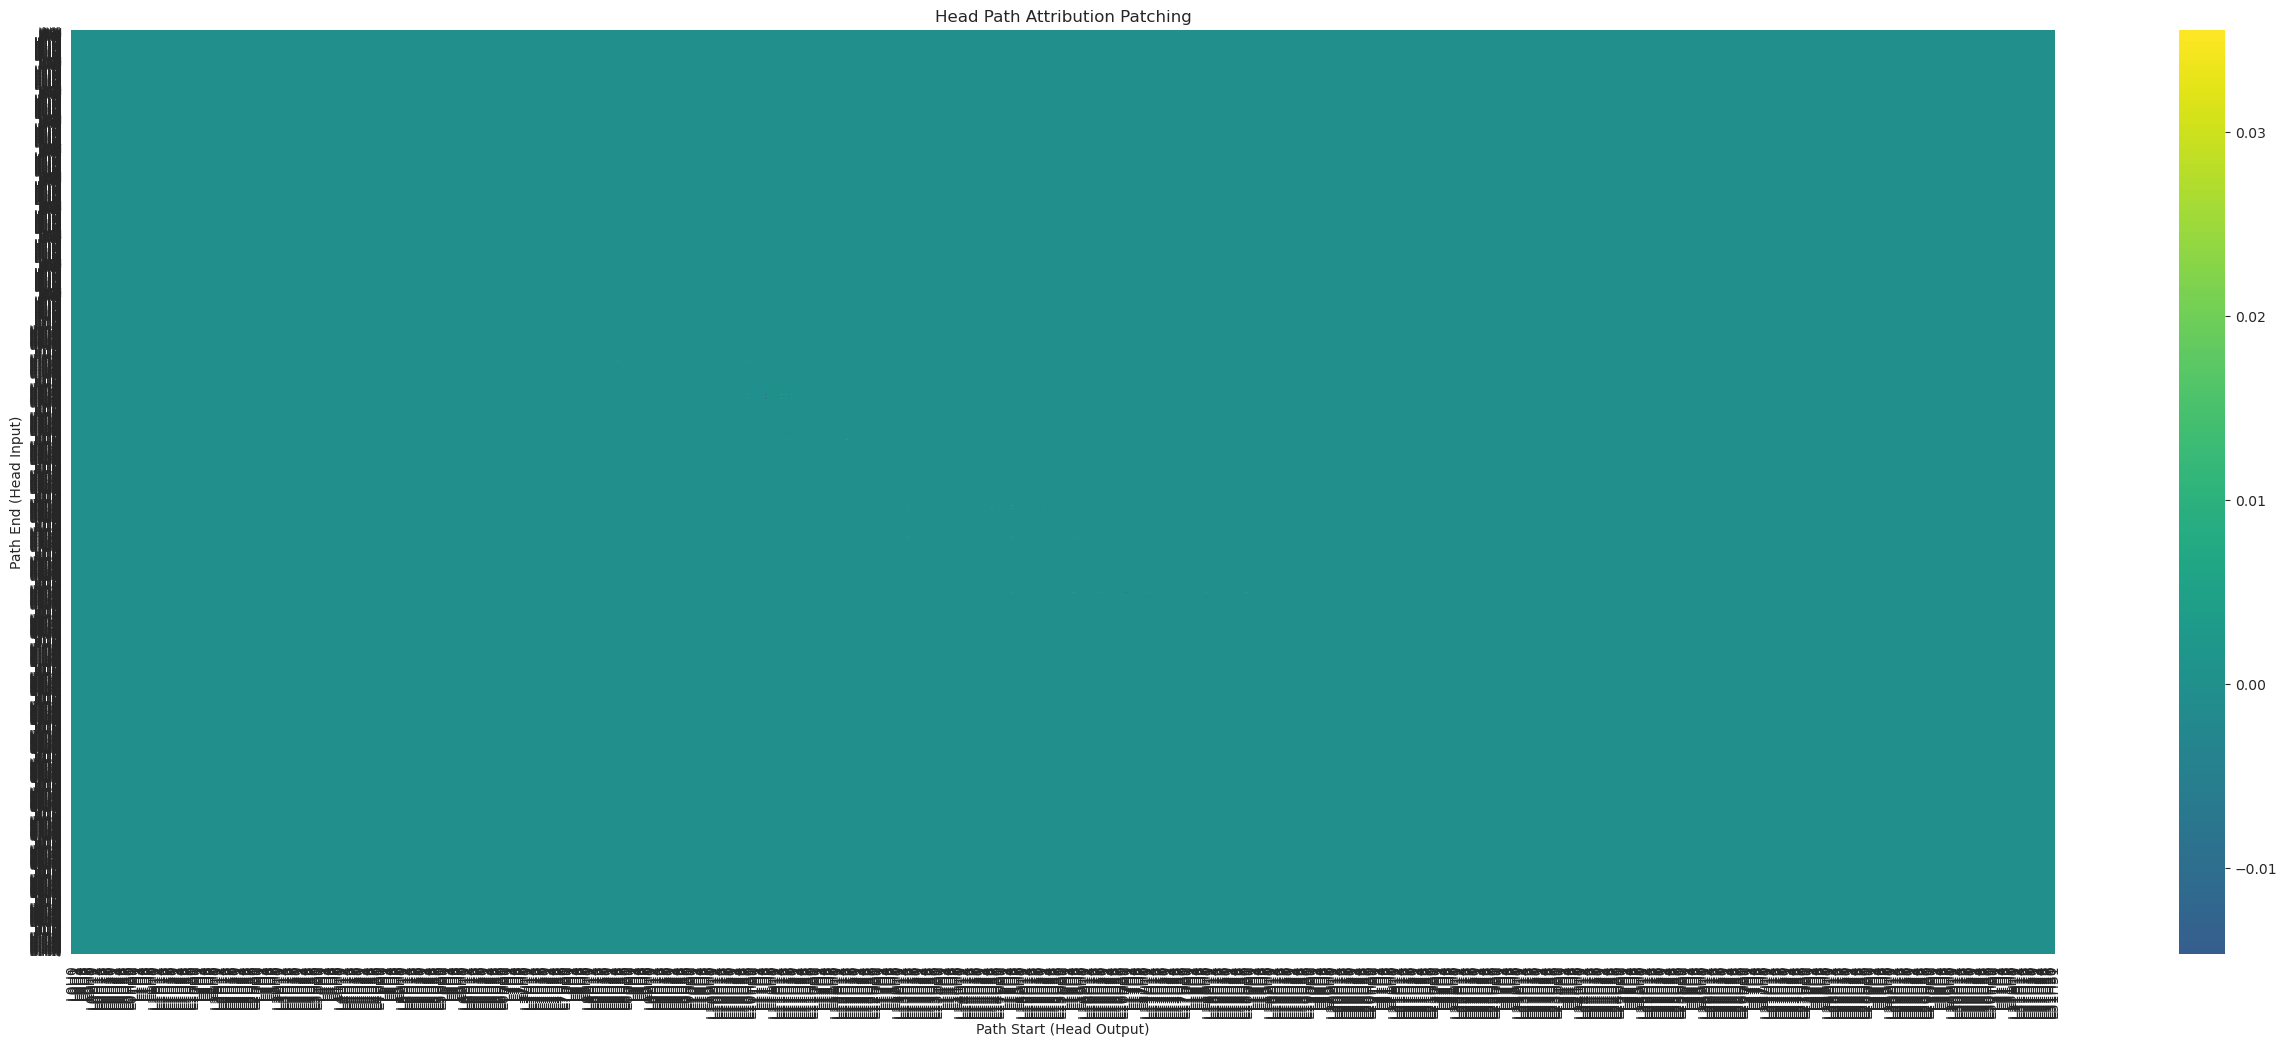

In [9]:
HEAD_NAMES = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [
    f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]
]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

head_pattern_attr, labels = attr_patch_head_pattern(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)

head_pattern_attr = einops.rearrange(
        head_pattern_attr,
        "(layer head) dest src -> layer head dest src",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
check_gpu_memory()


head_path_attr, end_labels, start_labels = attr_patch_head_path(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)


plt.figure(figsize=(32, 12))
sns.set_style("white")
sns.heatmap(head_path_attr.sum(-1).detach().numpy(), yticklabels=end_labels, xticklabels = start_labels, annot=False, cmap='viridis', center=0)
plt.yticks(fontsize = 5)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
# plt.savefig('plots/head_path_attribution_patching.png')
plt.plot()


Function 'attr_patch_head_out' executed in 30.7880 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52190.00 MB


[]

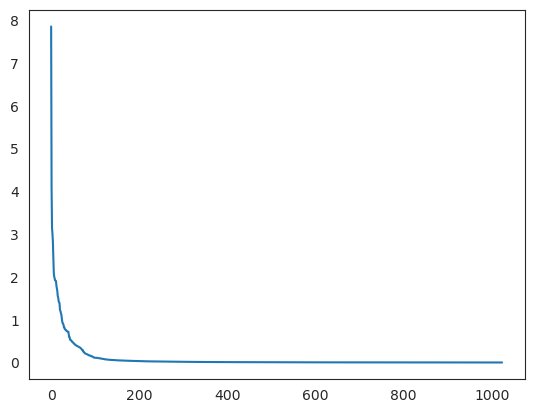

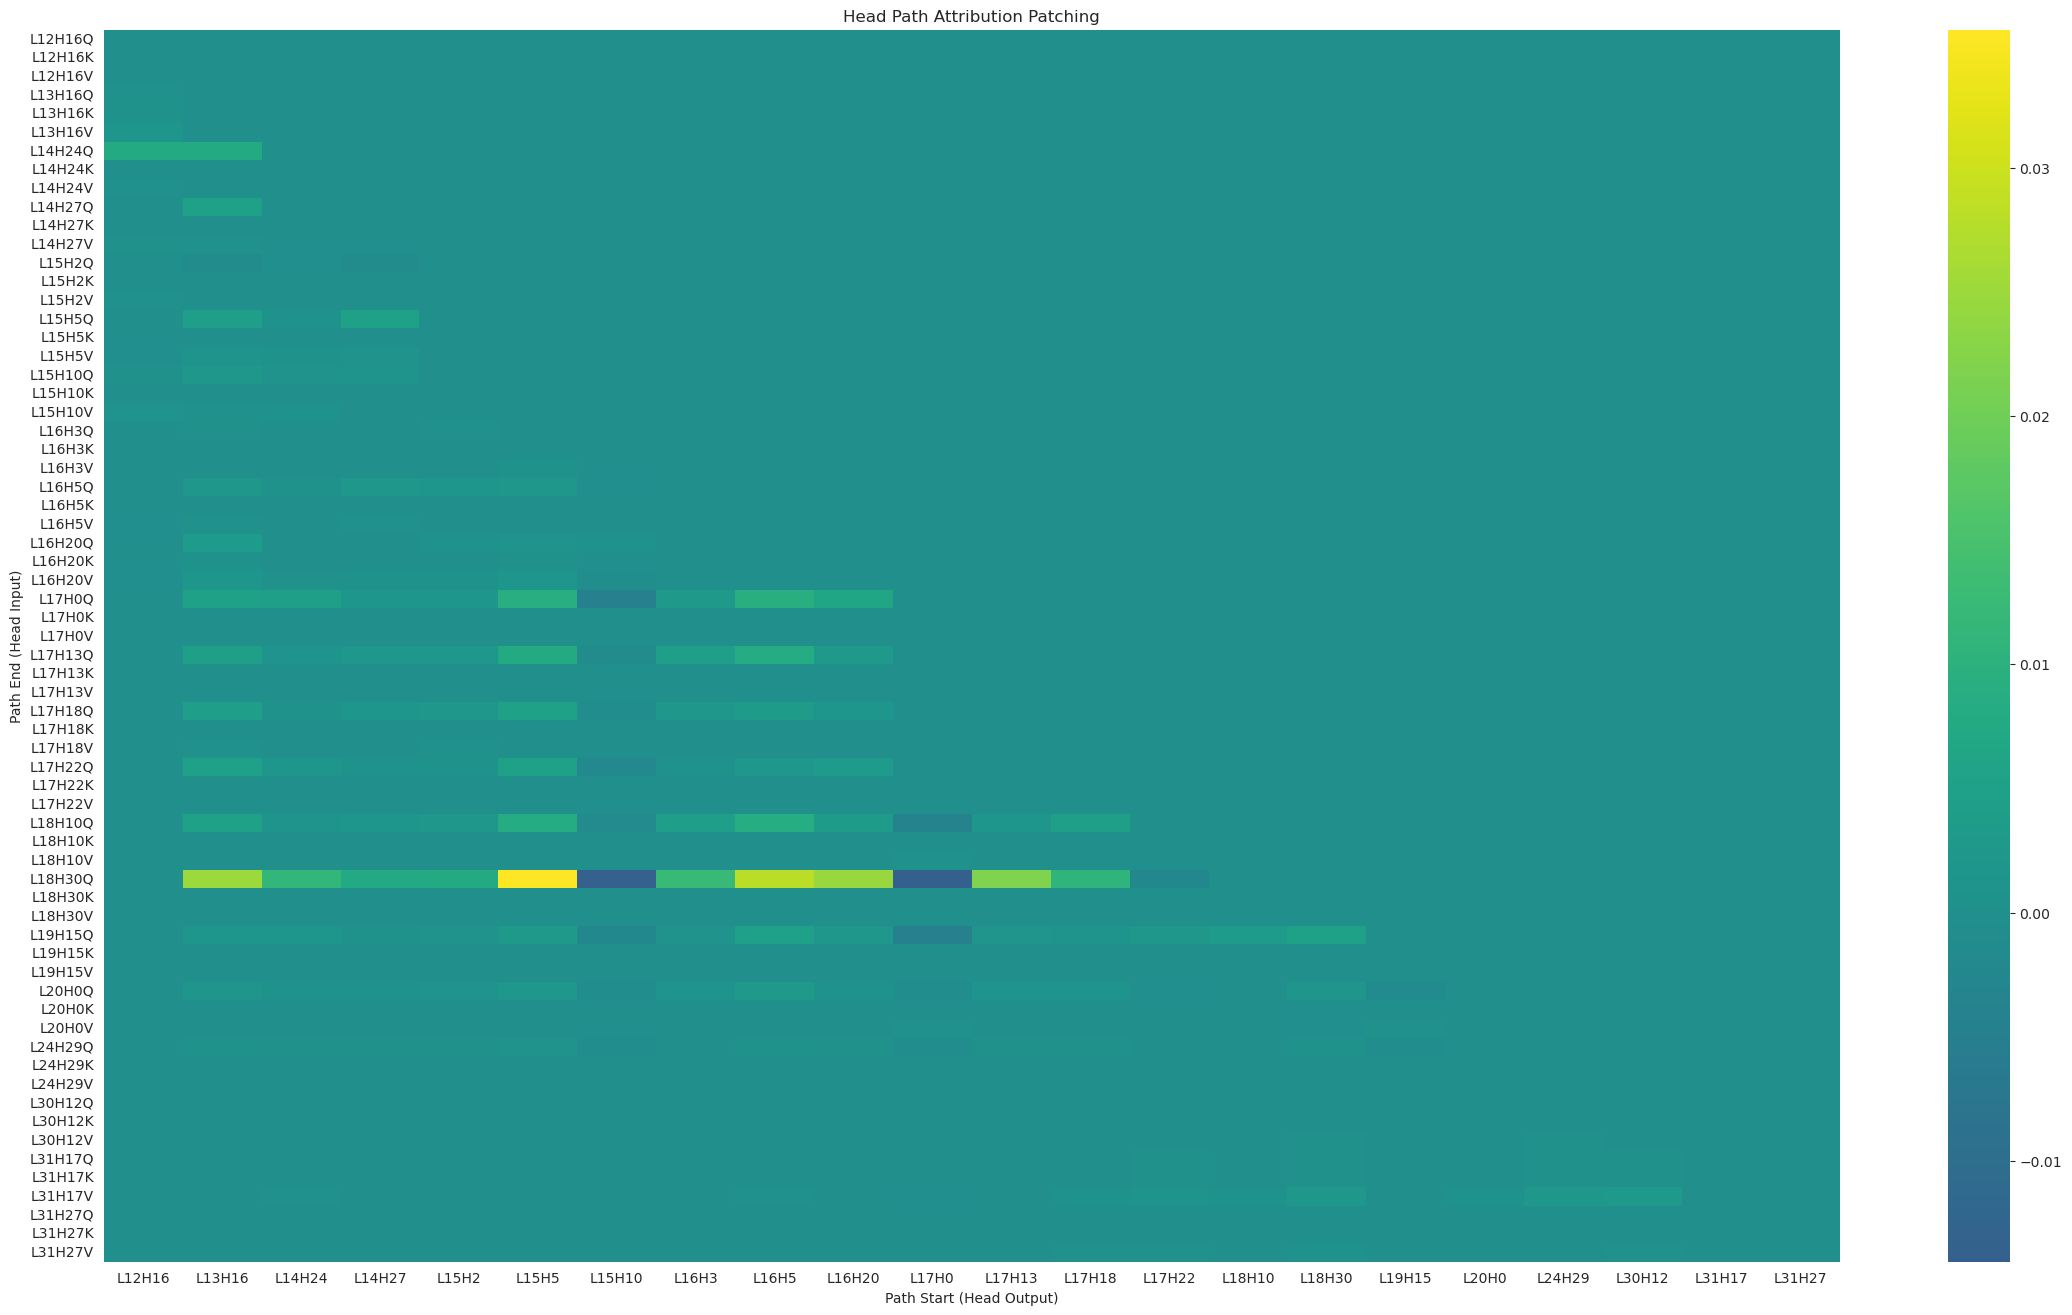

In [10]:
head_out_attr, head_out_labels = attr_patch_head_out(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)

sum_head_out_attr = einops.reduce(
    head_out_attr,
    "(layer head) pos -> layer head",
    "sum",
    layer=model.cfg.n_layers,
    head=model.cfg.n_heads,
)
check_gpu_memory()


head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
top_head_indices = head_out_indices[:22].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

plt.plot(head_out_values.detach().numpy())

for i in top_head_indices:
    i = i.item()
    top_start_indices.append(i)
    top_start_labels.append(start_labels[i])
    for j in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])

top_head_path_attr = einops.rearrange(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    "(head_end qkv) head_start -> qkv head_end head_start",
    qkv=3,
)
check_gpu_memory()

plt.figure(figsize=(28, 16))
sns.heatmap(head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1).detach().numpy(), yticklabels = top_end_labels, xticklabels= top_start_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
# plt.savefig('plots/head_path_2_attribution_patching.png')
plt.plot()


In [117]:
type(head_path_attr)

torch.Tensor

In [126]:
num_elements = head_path_attr.numel()

# Determine the size of each element in bytes
# For example, float32 (default for torch.randn) is 4 bytes
element_size = head_path_attr.element_size()

# Calculate the total memory usage in bytes
total_memory_bytes = num_elements * element_size

# Convert bytes to megabytes for easier readability
total_memory_megabytes = total_memory_bytes / (1024 ** 2)

print(f"Expected memory usage: {total_memory_bytes} bytes ({total_memory_megabytes:.2f} MB)")

Expected memory usage: 503316480 bytes (480.00 MB)


In [127]:
# Save the tensor
torch.save(head_path_attr, 'patch_results/head_path_attr.pt')

In [128]:
# Calculate the sum over the last dimension to get the correlation values
correlation_values = head_path_attr.sum(-1)

# Calculate mean and standard deviation
mean_value = correlation_values.mean().item()
std_dev = correlation_values.std().item()

# Define the threshold as mean + std_dev
threshold = mean_value + std_dev

# Calculate the absolute values of the correlation matrix
abs_correlation_values = correlation_values.abs()

# Create a boolean mask where absolute values are greater than the threshold
mask = abs_correlation_values > 0.0022 #threshold

# Get the indices where the condition is met
indices = mask.nonzero(as_tuple=True)

# Convert indices to a list of tuples
path_indices = list(zip(indices[0].tolist(), indices[1].tolist()))

print(f"Threshold: {threshold}")
print("Indices of paths with absolute correlation values greater than the threshold:")
print(path_indices)

# Create a new matrix for plotting with values above the threshold
thresholded_matrix = correlation_values.clone()
thresholded_matrix[~mask] = np.nan  # Set values not meeting the threshold to NaN for better heatmap visualization


# # Plotting the heatmap
# plt.figure(figsize=(28, 16))
# sns.heatmap(thresholded_matrix.detach().numpy(), yticklabels=top_end_labels, xticklabels=top_start_labels, annot=False, cmap='viridis', center=0)
# plt.xlabel('Path Start (Head Output)')
# plt.ylabel('Path End (Head Input)')
# plt.title('Head Path Attribution Patching 2 (Thresholded)')
# # plt.savefig('plots/head_path_2_attribution_patching_thresholded.png')
# plt.show()

Threshold: 5.225775926476217e-05
Indices of paths with absolute correlation values greater than the threshold:
[(1076, 281), (1113, 281), (1200, 281), (1200, 296), (1200, 322), (1200, 338), (1200, 349), (1200, 358), (1200, 366), (1200, 367), (1202, 366), (1211, 358), (1211, 366), (1211, 371), (1224, 349), (1224, 358), (1224, 366), (1224, 371), (1225, 349), (1225, 358), (1225, 366), (1225, 371), (1226, 358), (1226, 366), (1226, 371), (1265, 358), (1265, 366), (1265, 400), (1275, 394), (1298, 281), (1298, 358), (1298, 371), (1361, 366), (1361, 400), (1416, 358), (1416, 366), (1416, 394), (1416, 400), (1416, 403), (1416, 432), (1425, 426), (1425, 432), (1455, 426), (1455, 432), (1455, 475), (1470, 432), (1482, 432), (1551, 432), (1551, 475), (1551, 485), (1580, 432), (1580, 485), (1590, 475), (1590, 485), (1596, 432), (1629, 485), (1632, 432), (1632, 472), (1632, 485), (1632, 490), (1632, 494), (1632, 515), (1632, 517), (1632, 526), (1632, 530), (1632, 532), (1632, 543), (1665, 432), (167

In [129]:
len(path_indices)

164

In [141]:
circuit_dictionary = {"indices":[],
                      "labels":[]}

for i, j in path_indices:
    circuit_dictionary["indices"].append((i, j))
    circuit_dictionary["labels"].append((end_labels[i], start_labels[j]))
    
# Specify the file name
file_name = 'circuits/codellama/infoRet_30prompts_data3_thres00022.json'

# Save the dictionary as a JSON file
with open(file_name, 'w') as json_file:
    json.dump(circuit_dictionary, json_file, indent=4)

In [140]:
len(list(circuit_dictionary['labels']))

164

In [132]:
keys_comps = []
for i in range(len(list(circuit_dictionary['labels']))):
    ind = list(circuit_dictionary['indices'])[i][1]
    layer_ind = ind//32
    head_ind = ind%32
    # key = f'blocks.{layer_ind}.attn.hook_result'
    keys_comps.append((layer_ind, head_ind))
print(len(keys_comps))

for i in range(len(list(circuit_dictionary['labels']))):
    ind = list(circuit_dictionary['indices'])[i][0]
    # print(ind//(32*3), (ind%(32*3))//3)
    layer_ind = ind//32
    head_ind = ind%32
    # key = f'blocks.{layer_ind}.attn.hook_result'
    keys_comps.append((layer_ind, head_ind))
print(len(keys_comps))

164
328


In [137]:
list_length = len(keys_comps)

# Generate a new list of random tuples with the same length
random_keys_comps = [(random.randint(0, 31), random.randint(0, 31)) for _ in range(list_length)]

print(random_keys_comps)

[(31, 13), (29, 22), (0, 13), (23, 9), (12, 29), (4, 24), (22, 8), (5, 11), (6, 26), (21, 21), (23, 29), (27, 17), (19, 19), (13, 21), (22, 20), (21, 14), (29, 29), (29, 22), (26, 18), (28, 9), (21, 6), (25, 9), (23, 6), (23, 23), (0, 17), (10, 26), (15, 0), (21, 17), (22, 25), (7, 0), (2, 14), (25, 6), (17, 30), (22, 26), (5, 10), (8, 7), (17, 6), (5, 27), (19, 22), (13, 23), (4, 3), (19, 30), (19, 10), (6, 21), (6, 7), (14, 24), (3, 26), (30, 12), (23, 29), (30, 5), (27, 6), (8, 25), (29, 7), (31, 26), (27, 27), (20, 12), (27, 19), (30, 3), (25, 19), (11, 5), (7, 5), (24, 19), (3, 18), (22, 23), (28, 29), (25, 10), (2, 6), (21, 22), (22, 12), (27, 29), (4, 2), (16, 25), (20, 11), (14, 7), (1, 31), (10, 14), (27, 20), (7, 6), (10, 11), (24, 6), (21, 19), (1, 29), (17, 9), (11, 19), (29, 5), (8, 27), (13, 4), (27, 30), (31, 18), (22, 7), (16, 17), (11, 4), (1, 13), (10, 12), (4, 4), (10, 9), (27, 9), (17, 18), (30, 5), (26, 29), (22, 5), (7, 17), (11, 29), (29, 11), (17, 22), (15, 31),

In [133]:
# get mean activations 
mean_activations = {}
for l in range(model.cfg.n_layers):
    key = f'blocks.{l}.attn.hook_result'
    mean_activations[l] = torch.sum(clean_cache_first[key], dim=0).to("cpu")/28 #.shape
check_gpu_memory()

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 16.27 MB  Reserved: 42.00 MB


In [138]:
def ablate_setter(corrupted_activation, layer_ind, clean_activation, mean_activation=mean_activations,  keys_comps=random_keys_comps):
    for hed in range(32):
        if (layer_ind, hed) not in keys_comps:
            # print("here")
            mean_activation_broadcasted = mean_activation[layer_ind][:, hed, :].unsqueeze(0).expand(28, -1, -1)
            # Replace the values at the 3rd dimension of "hed" in new_cache[key]
            clean_activation[:, :, hed, :] = mean_activation_broadcasted
    return clean_activation

def ablating_hook(corrupted_activation, layer_ind, hook, clean_activation, mean_activation=mean_activations,  keys_comps=random_keys_comps):
    return ablate_setter(corrupted_activation, layer_ind, clean_activation, mean_activation=mean_activations,  keys_comps=random_keys_comps)

hooks_tuple = []

for l in range(model.cfg.n_layers):
    key = f'blocks.{l}.attn.hook_result'
    
    # Make a partial copy of the original cache for the current key
    new_cache_temp = clean_cache_first[key].clone()
    
    current_hook = partial(
    ablating_hook,
    layer_ind=l,
    clean_activation = new_cache_temp
    )   
    hooks_tuple.append((key, current_hook))

print(type(hooks_tuple))
check_gpu_memory()

patched_logits = model.to("cpu").run_with_hooks(
             clean_tokens, fwd_hooks=hooks_tuple, bwd_hooks=None)
# print(patched_logits)
check_gpu_memory()

<class 'list'>
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 16.27 MB  Reserved: 42.00 MB
Moving model to device:  cpu
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 16.27 MB  Reserved: 42.00 MB


In [139]:
model_answers = torch.argmax(patched_logits[:, -1, :], dim=-1)
for some_ind in range(len(model_answers)):
    print("Predicted: ", model.to_string(model_answers[some_ind]))
    print("Act answer: ", answers[some_ind][0])

Predicted:  

Act answer:  D
Predicted:  

Act answer:  J
Predicted:  

Act answer:  A
Predicted:  

Act answer:  E
Predicted:  

Act answer:  H
Predicted:  

Act answer:  G
Predicted:  

Act answer:  J
Predicted:  

Act answer:  E
Predicted:  

Act answer:  K
Predicted:  

Act answer:  B
Predicted:  

Act answer:  F
Predicted:  

Act answer:  D
Predicted:  

Act answer:  B
Predicted:  

Act answer:  H
Predicted:  

Act answer:  G
Predicted:  

Act answer:  C
Predicted:  

Act answer:  C
Predicted:  

Act answer:  B
Predicted:  

Act answer:  A
Predicted:  

Act answer:  E
Predicted:  

Act answer:  I
Predicted:  

Act answer:  H
Predicted:  

Act answer:  C
Predicted:  

Act answer:  A
Predicted:  

Act answer:  H
Predicted:  

Act answer:  K
Predicted:  

Act answer:  C
Predicted:  

Act answer:  A


In [101]:
delete_variable("corrupted_cache_first")
delete_variable("corrupted_grad_cache_first")

Function 'attr_patch_residual' executed in 1.7422 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52192.00 MB


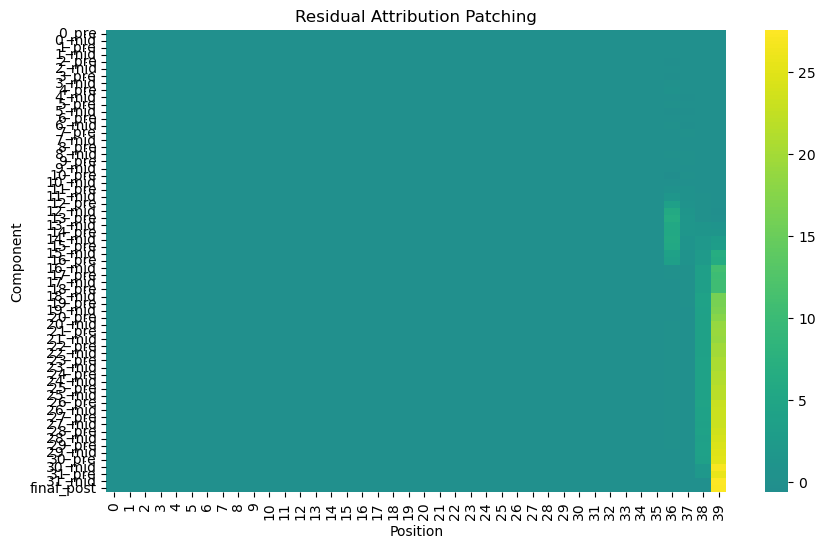

Function 'attr_patch_layer_out' executed in 1.7400 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52192.00 MB
['L0H0', 'L0H1', 'L0H2', 'L0H3', 'L0H4']
['L0H0+', 'L0H0-', 'L0H1+', 'L0H1-', 'L0H2+']
['L0H0Q', 'L0H0K', 'L0H0V', 'L0H1Q', 'L0H1K']
Function 'attr_patch_head_out' executed in 29.3359 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52192.00 MB
Function 'attr_patch_head_pattern' executed in 0.2302 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52192.00 MB
Function 'attr_patch_head_path' executed in 233.1665 seconds
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52192.00 MB
Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52192.00 MB


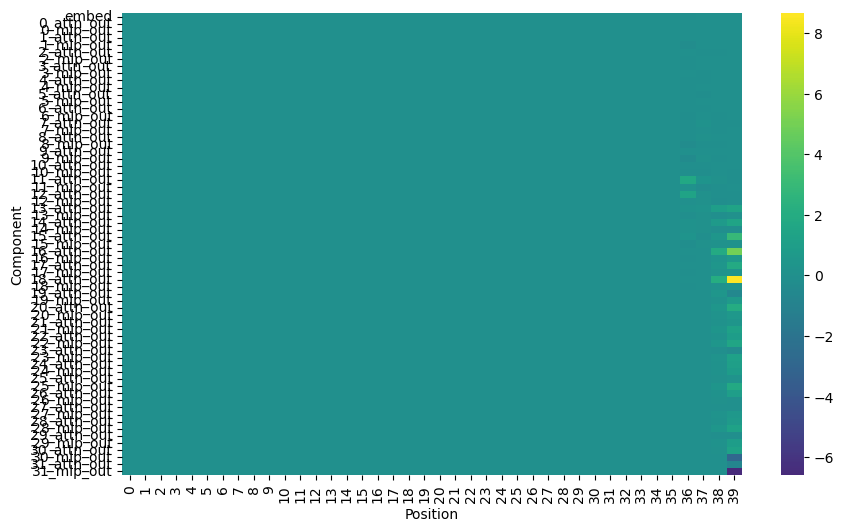

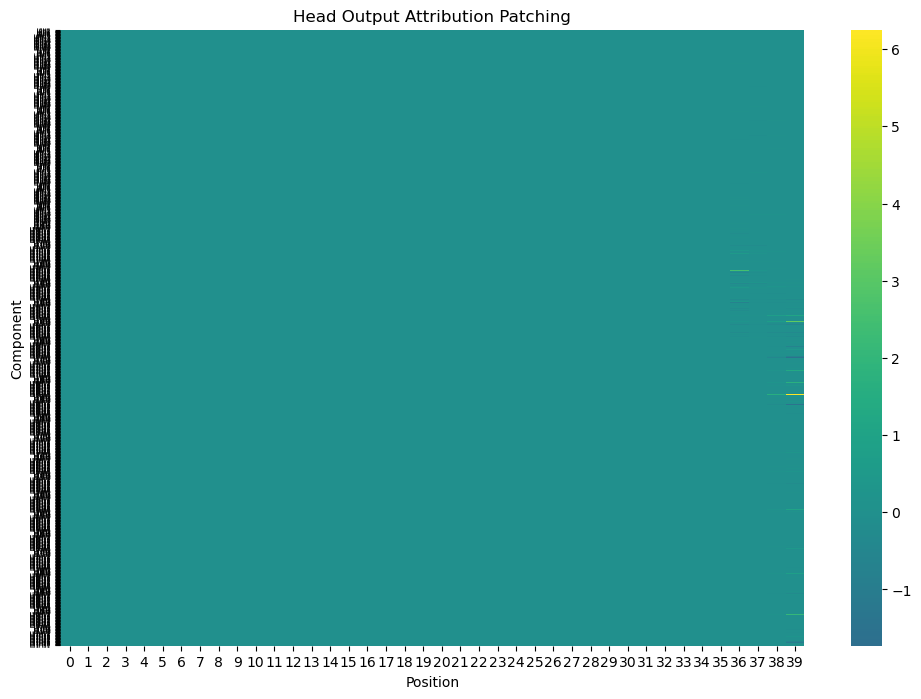

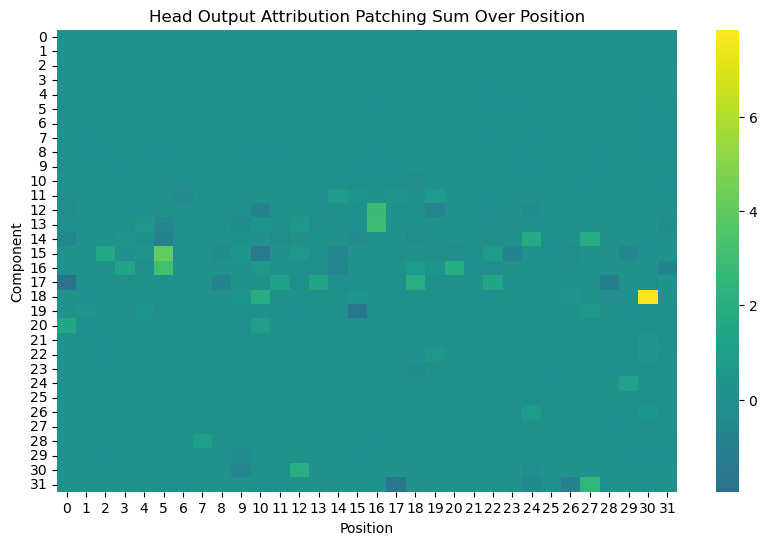

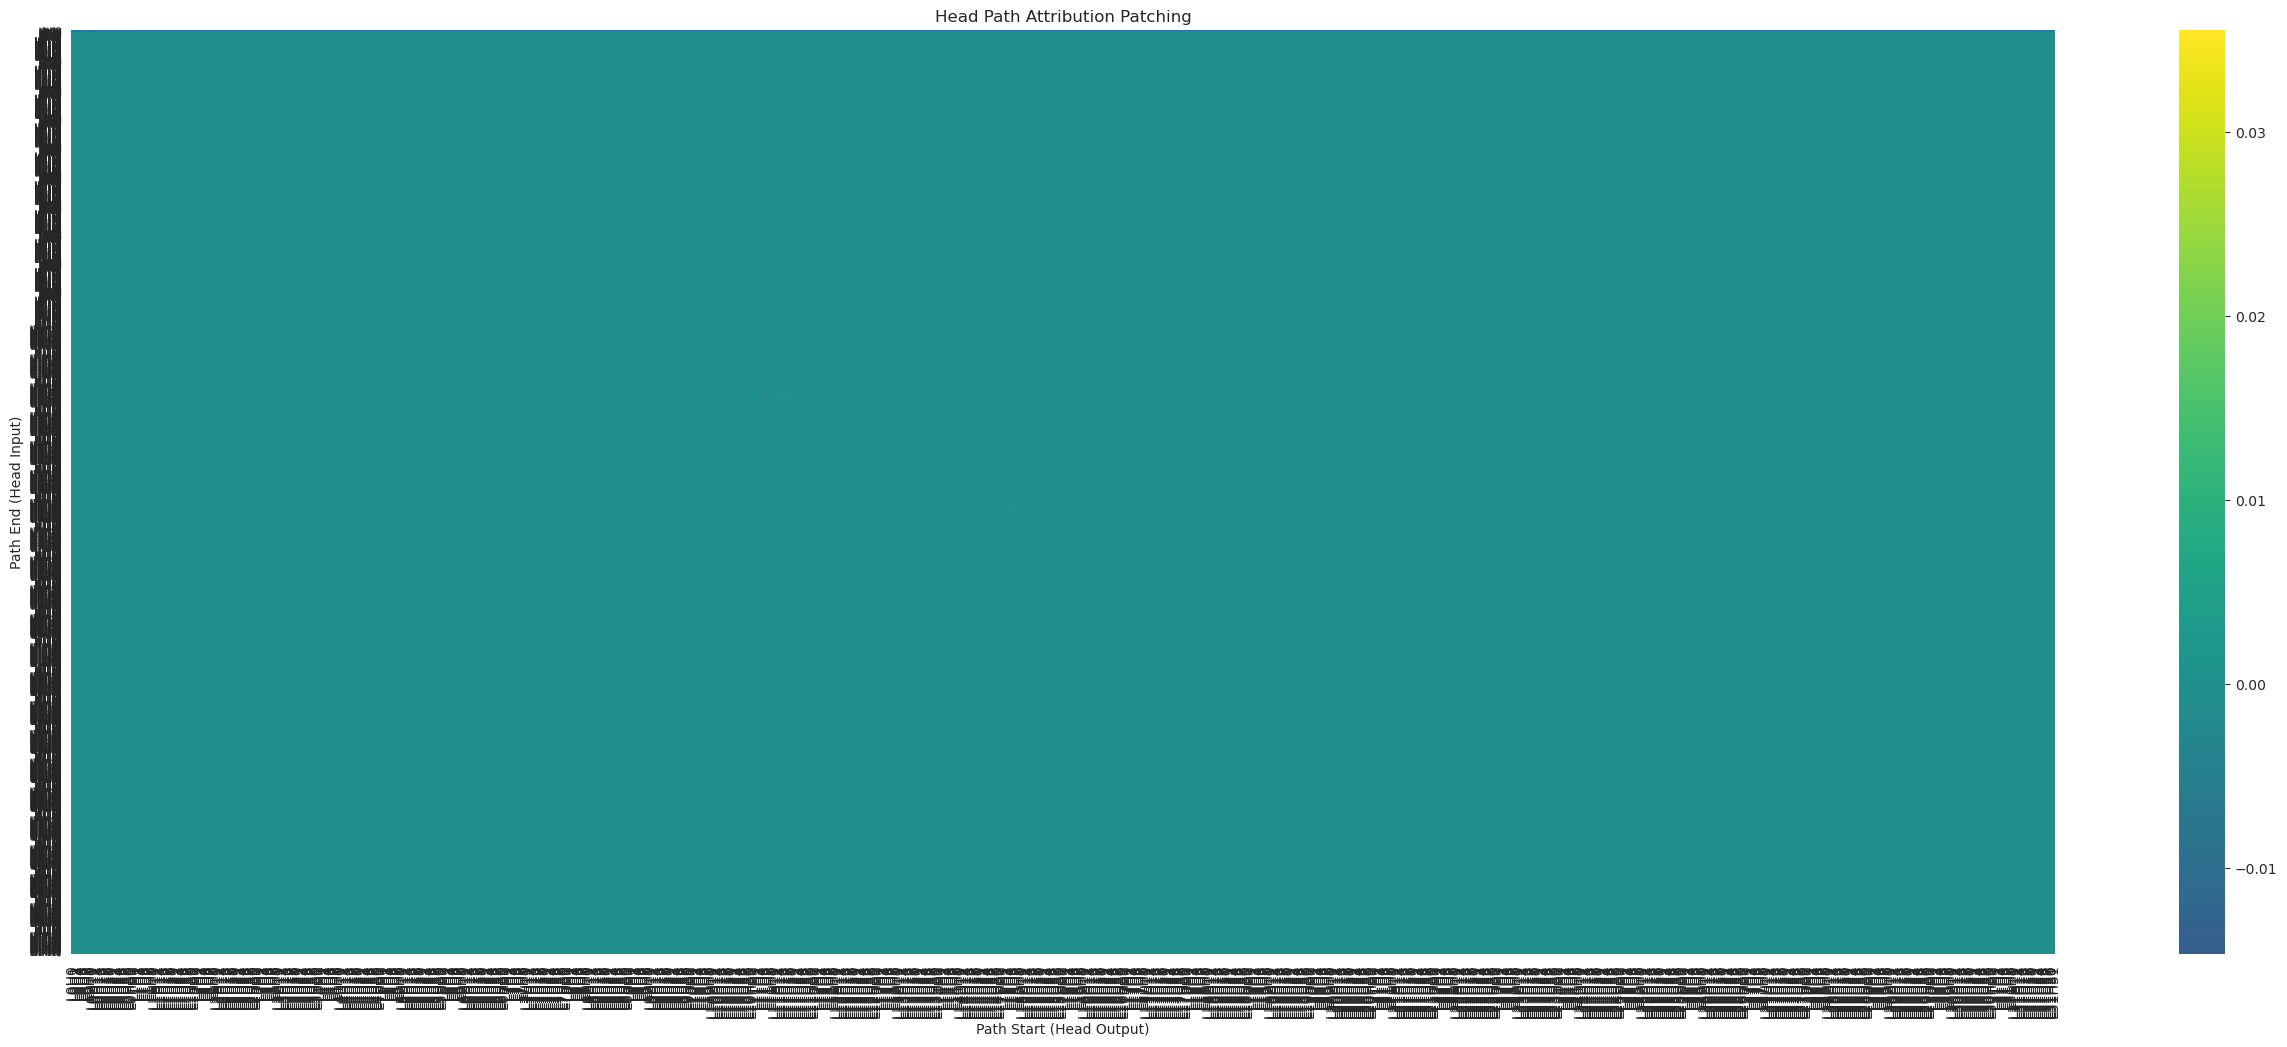

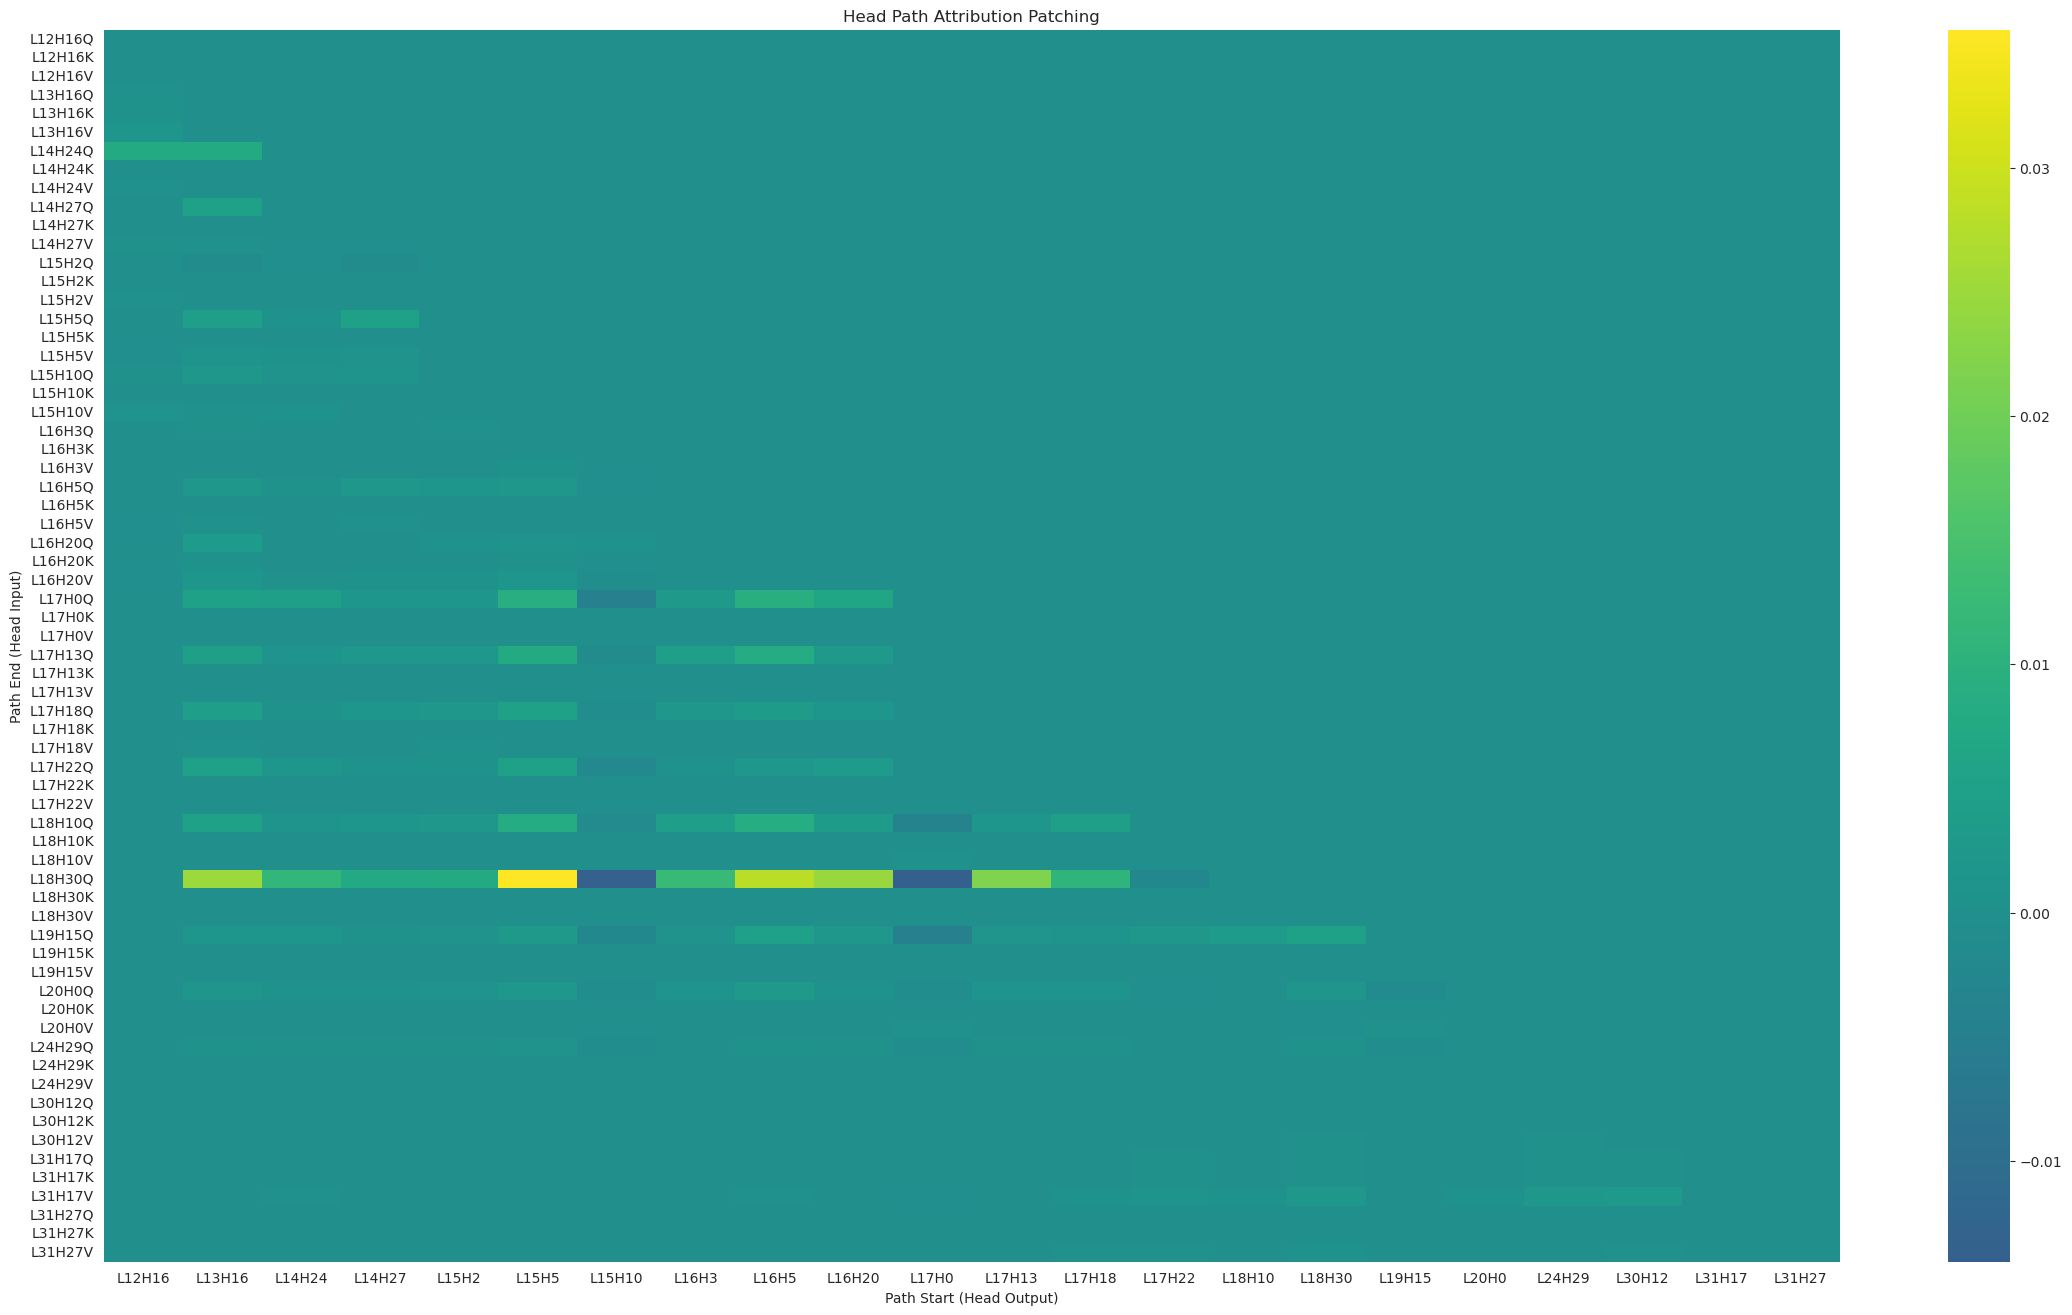

In [11]:
residual_attr, residual_labels = attr_patch_residual(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)
check_gpu_memory()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(residual_attr.detach().numpy(), yticklabels=residual_labels, annot=False, cmap='viridis', center=0)

plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Residual Attribution Patching')
plt.show()
# plt.savefig('plots/residual_attribution_patching.png')


layer_out_attr, layer_out_labels = attr_patch_layer_out(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)
check_gpu_memory()

plt.figure(figsize=(10, 6))
sns.heatmap(layer_out_attr.detach().numpy(), yticklabels=layer_out_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
# plt.savefig('plots/layer_attribution_patching.png')
plt.plot()

HEAD_NAMES = [
    f"L{l}H{h}" for l in range(model.cfg.n_layers) for h in range(model.cfg.n_heads)
]
HEAD_NAMES_SIGNED = [f"{name}{sign}" for name in HEAD_NAMES for sign in ["+", "-"]]
HEAD_NAMES_QKV = [
    f"{name}{act_name}" for name in HEAD_NAMES for act_name in ["Q", "K", "V"]
]
print(HEAD_NAMES[:5])
print(HEAD_NAMES_SIGNED[:5])
print(HEAD_NAMES_QKV[:5])

head_out_attr, head_out_labels = attr_patch_head_out(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)

sum_head_out_attr = einops.reduce(
    head_out_attr,
    "(layer head) pos -> layer head",
    "sum",
    layer=model.cfg.n_layers,
    head=model.cfg.n_heads,
)
check_gpu_memory()

plt.figure(figsize=(12, 8))
sns.heatmap(head_out_attr.detach().numpy(), yticklabels=head_out_labels, annot=False, cmap='viridis', center=0)
plt.yticks(fontsize = 4)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching')
# plt.savefig('plots/head_op_attribution_patching.png')
plt.plot()

plt.figure(figsize=(10, 6))
sns.heatmap(sum_head_out_attr.detach().numpy(), annot=False, cmap='viridis', center=0)
plt.xlabel('Position')
plt.ylabel('Component')
plt.title('Head Output Attribution Patching Sum Over Position')
# plt.savefig('plots/head_sum_attribution_patching.png')
plt.plot()


head_pattern_attr, labels = attr_patch_head_pattern(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)

head_pattern_attr = einops.rearrange(
        head_pattern_attr,
        "(layer head) dest src -> layer head dest src",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
check_gpu_memory()


head_path_attr, end_labels, start_labels = attr_patch_head_path(
    clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
)


plt.figure(figsize=(32, 12))
sns.set_style("white")
sns.heatmap(head_path_attr.sum(-1).detach().numpy(), yticklabels=end_labels, xticklabels = start_labels, annot=False, cmap='viridis', center=0)
plt.yticks(fontsize = 5)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
# plt.savefig('plots/head_path_attribution_patching.png')
plt.plot()

head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
top_head_indices = head_out_indices[:22].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

plt.plot(head_out_values.detach().numpy())

for i in top_head_indices:
    i = i.item()
    top_start_indices.append(i)
    top_start_labels.append(start_labels[i])
    for j in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])

top_head_path_attr = einops.rearrange(
    head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
    "(head_end qkv) head_start -> qkv head_end head_start",
    qkv=3,
)
check_gpu_memory()

plt.figure(figsize=(28, 16))
sns.heatmap(head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1).detach().numpy(), yticklabels = top_end_labels, xticklabels= top_start_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
# plt.savefig('plots/head_path_2_attribution_patching.png')
plt.plot()
# interesting_heads = [ #path start
#     13 * model.cfg.n_heads + 16,
#     15 * model.cfg.n_heads + 5,
#     15 * model.cfg.n_heads + 10,
#     16 * model.cfg.n_heads + 5,
#     16 * model.cfg.n_heads + 20,
#     17 * model.cfg.n_heads + 0,

#     # path end 
#     # 18 * model.cfg.n_heads + 30,
#     17 * model.cfg.n_heads + 0,
#     17 * model.cfg.n_heads + 13,
#     17 * model.cfg.n_heads + 18,
#     17 * model.cfg.n_heads + 22,
#     18 * model.cfg.n_heads + 10,
#     18 * model.cfg.n_heads + 30,
#     19 * model.cfg.n_heads + 15,
# ]
# interesting_head_labels = [HEAD_NAMES[i] for i in interesting_heads]
# for head_index, label in zip(interesting_heads, interesting_head_labels):
#     in_paths = head_path_attr[3 * head_index : 3 * head_index + 3].sum(-1)
#     out_paths = head_path_attr[:, head_index].sum(-1)
#     out_paths = einops.rearrange(out_paths, "(layer_head qkv) -> qkv layer_head", qkv=3)
#     all_paths = torch.cat([in_paths, out_paths], dim=0)
#     all_paths = einops.rearrange(
#         all_paths,
#         "path_type (layer head) -> path_type layer head",
#         layer=model.cfg.n_layers,
#         head=model.cfg.n_heads,
#     )
#     fig, axs = plt.subplots(1,6, figsize=(34, 10))
#     facet_labels=["Query (In)",
#             "Key (In)",
#             "Value (In)",
#             "Query (Out)",
#             "Key (Out)",
#             "Value (Out)",
#         ]

#     for i in range(6):
#         fig = sns.heatmap(all_paths.cpu().detach().numpy()[i], ax = axs[i], xticklabels= model.to_str_tokens(clean_tokens[0]), cmap='viridis')
#         axs[i].set_title(facet_labels[i])
#         axs[i].set_xlabel('Head')
#         axs[i].set_ylabel('Layer')

#     plt.tight_layout()
#     plt.savefig(f'plots/interestingHeads_{head_index}_{label}_attribution_patching.png')
# # TODO - implement visualization for input/output paths per head


check_gpu_memory()

In [24]:
print("done")

done


Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52194.00 MB


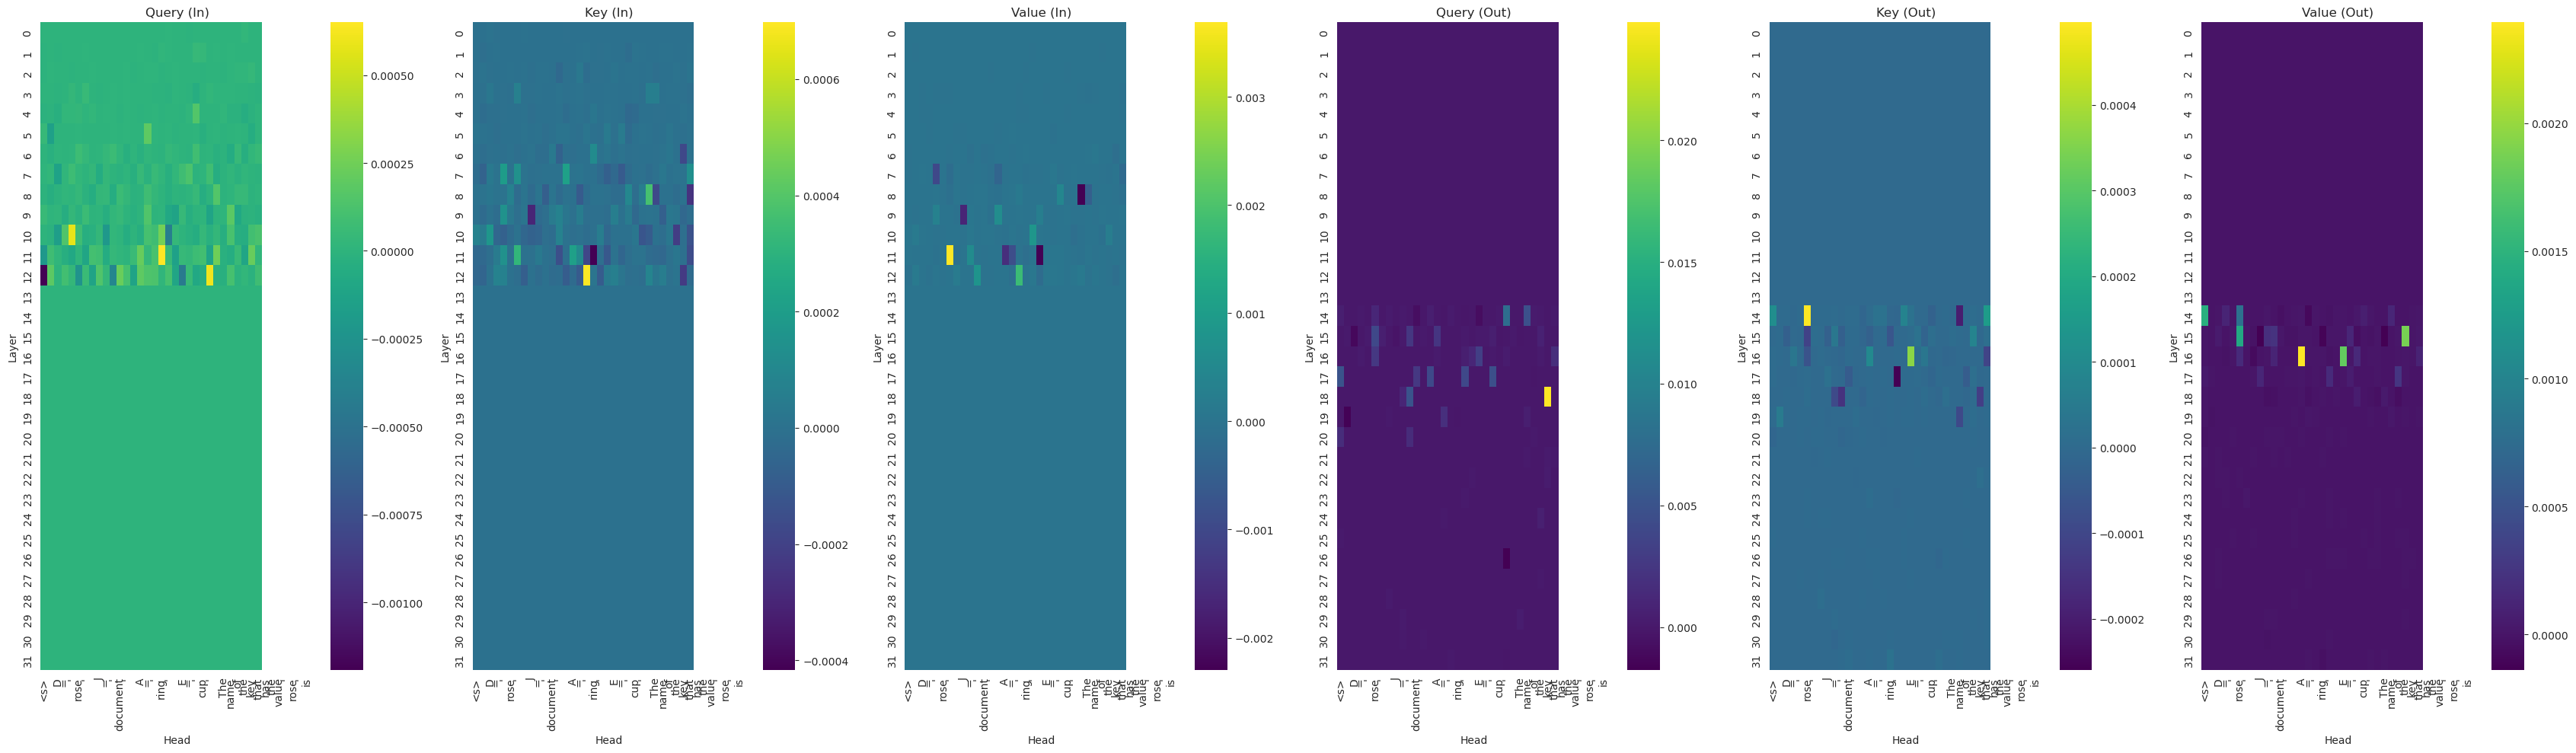

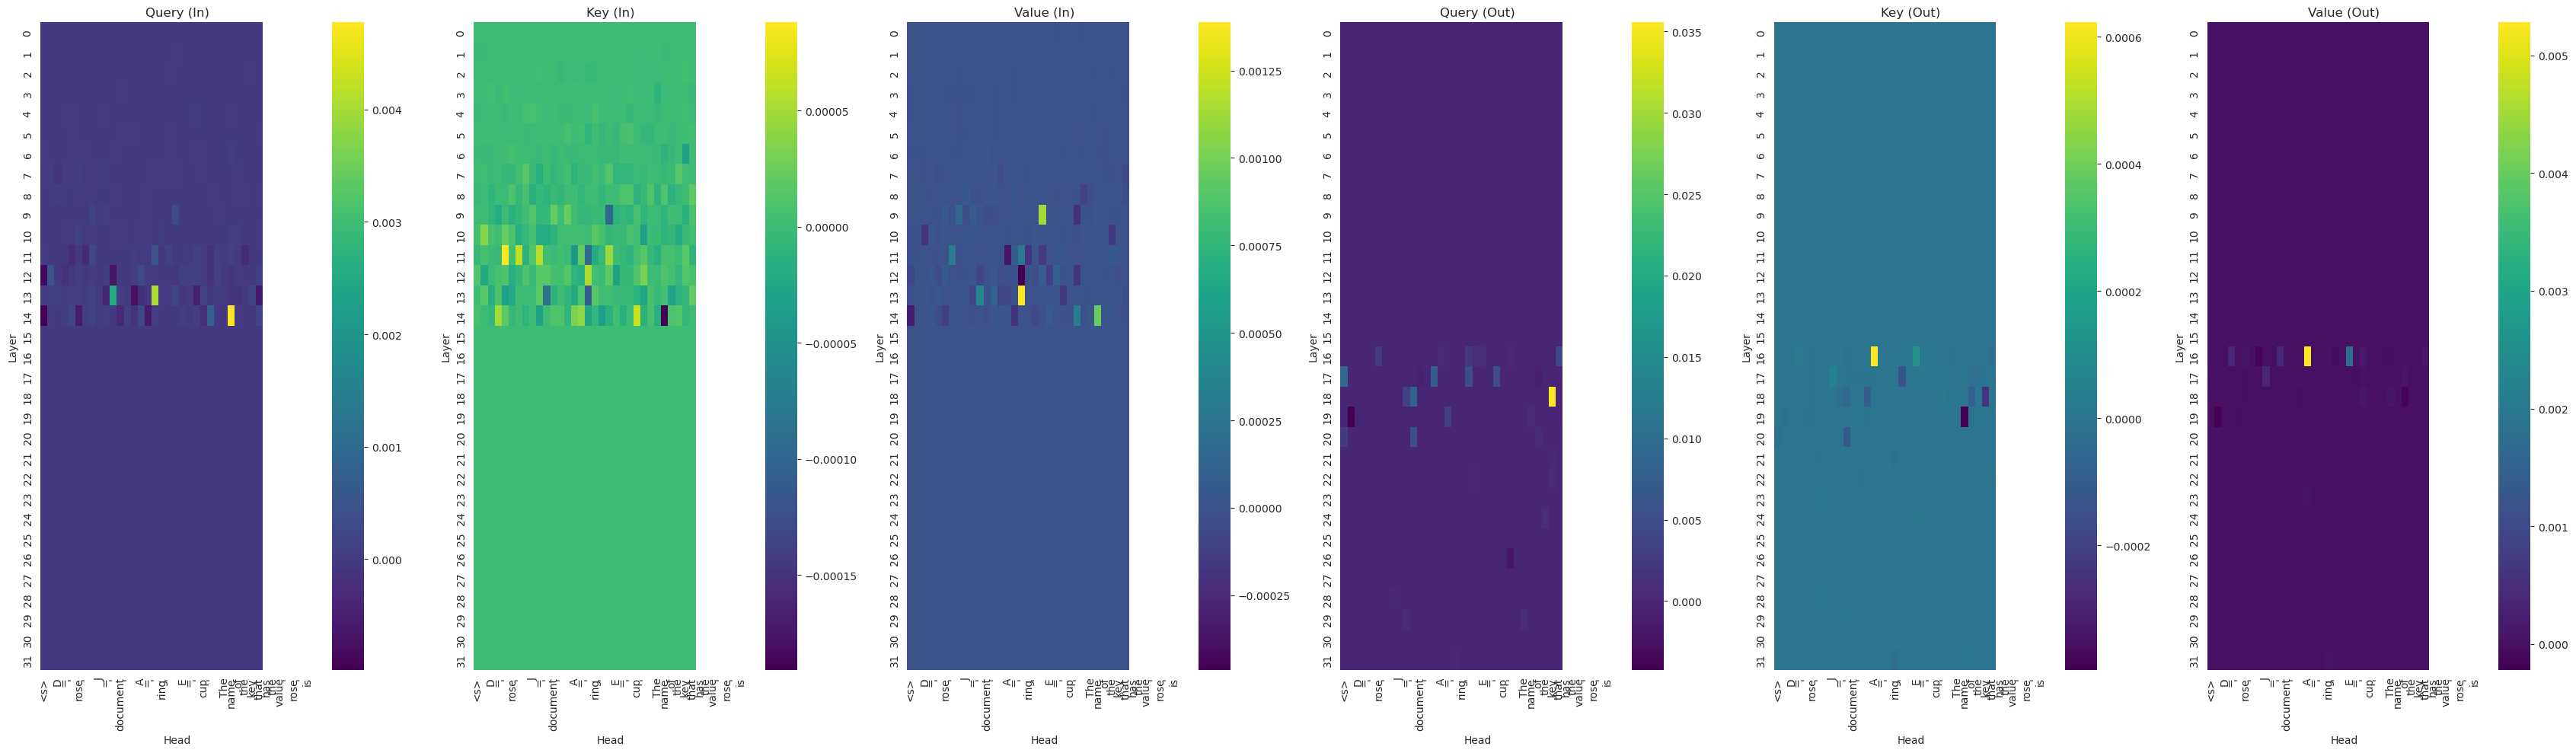

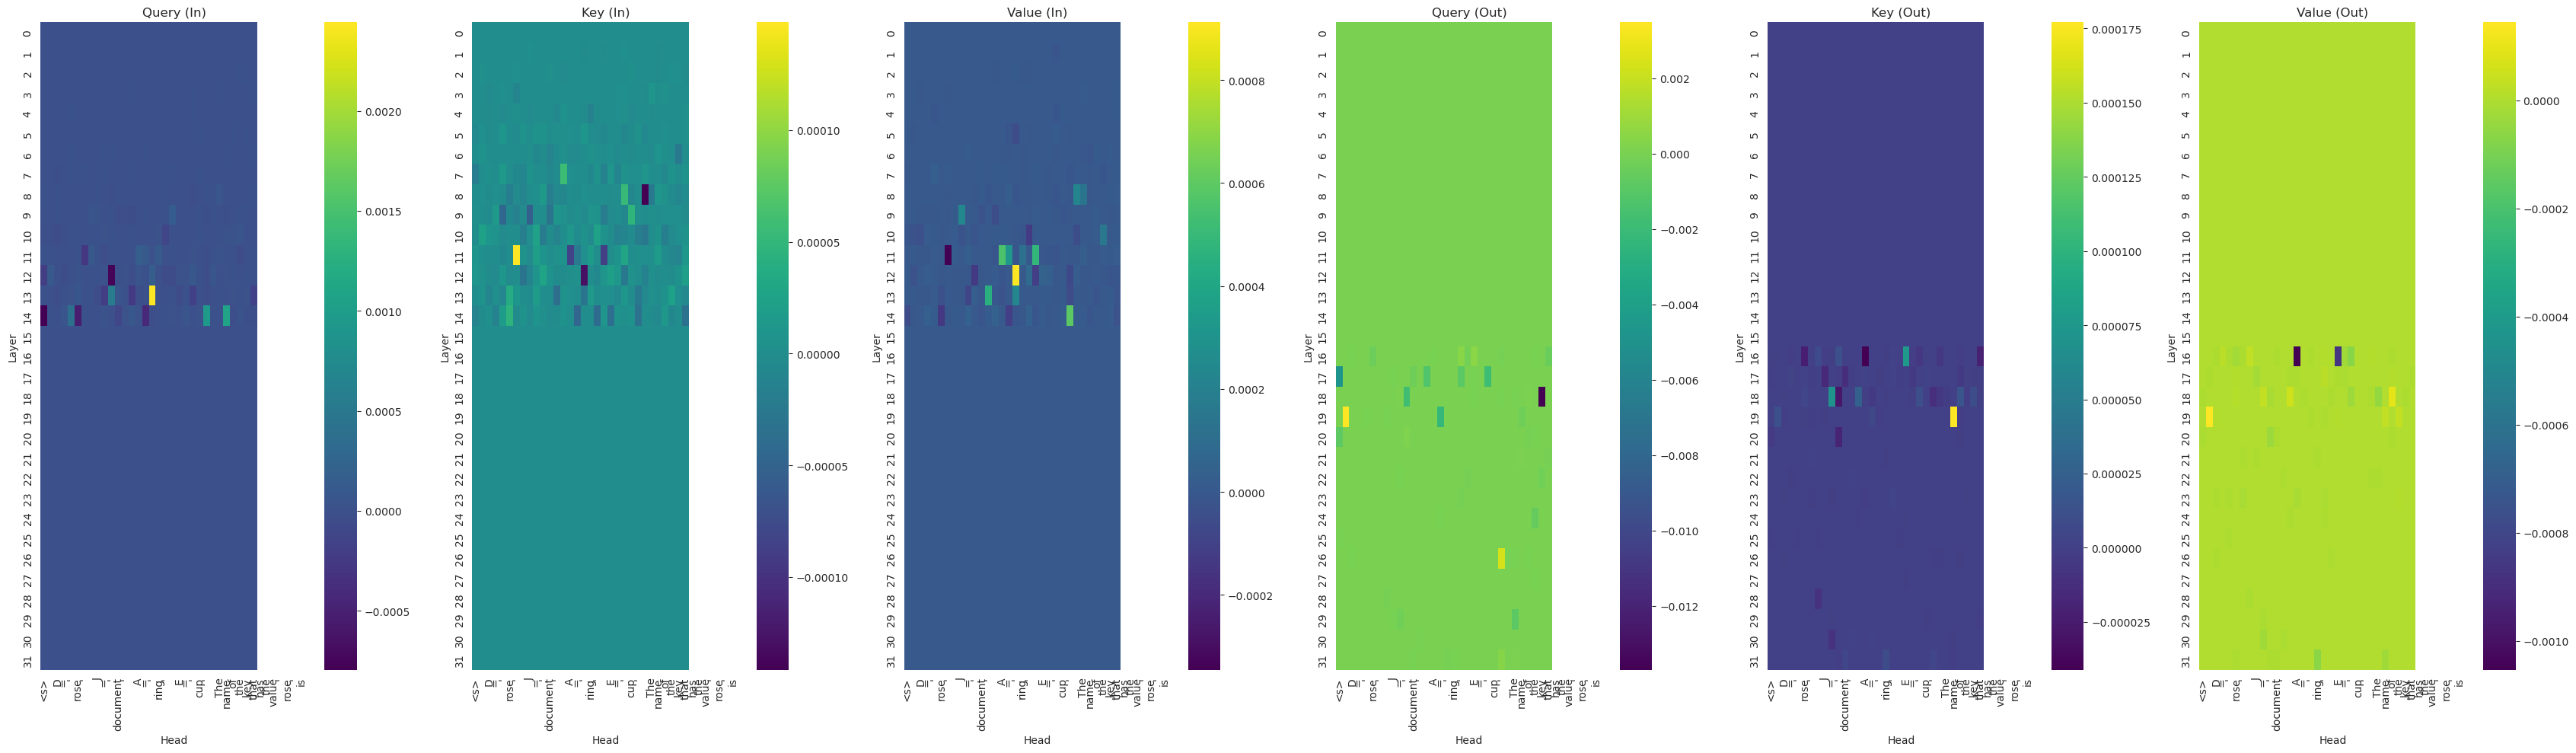

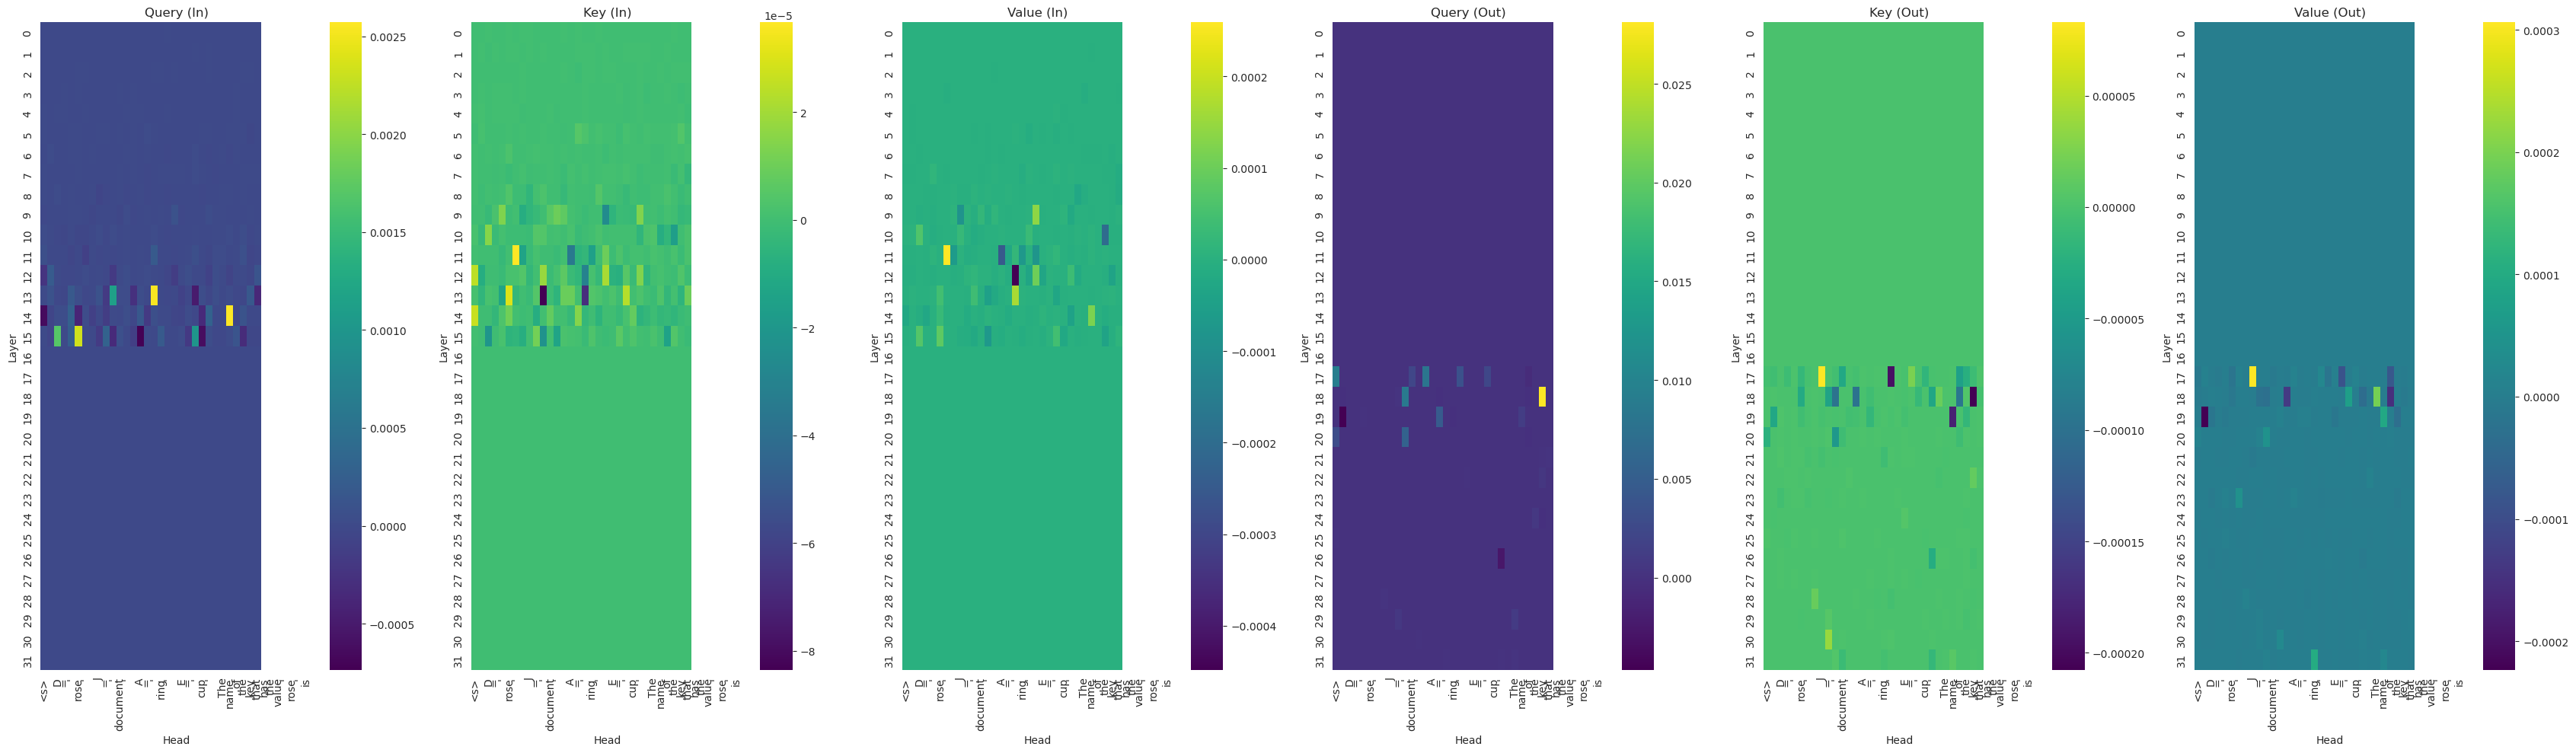

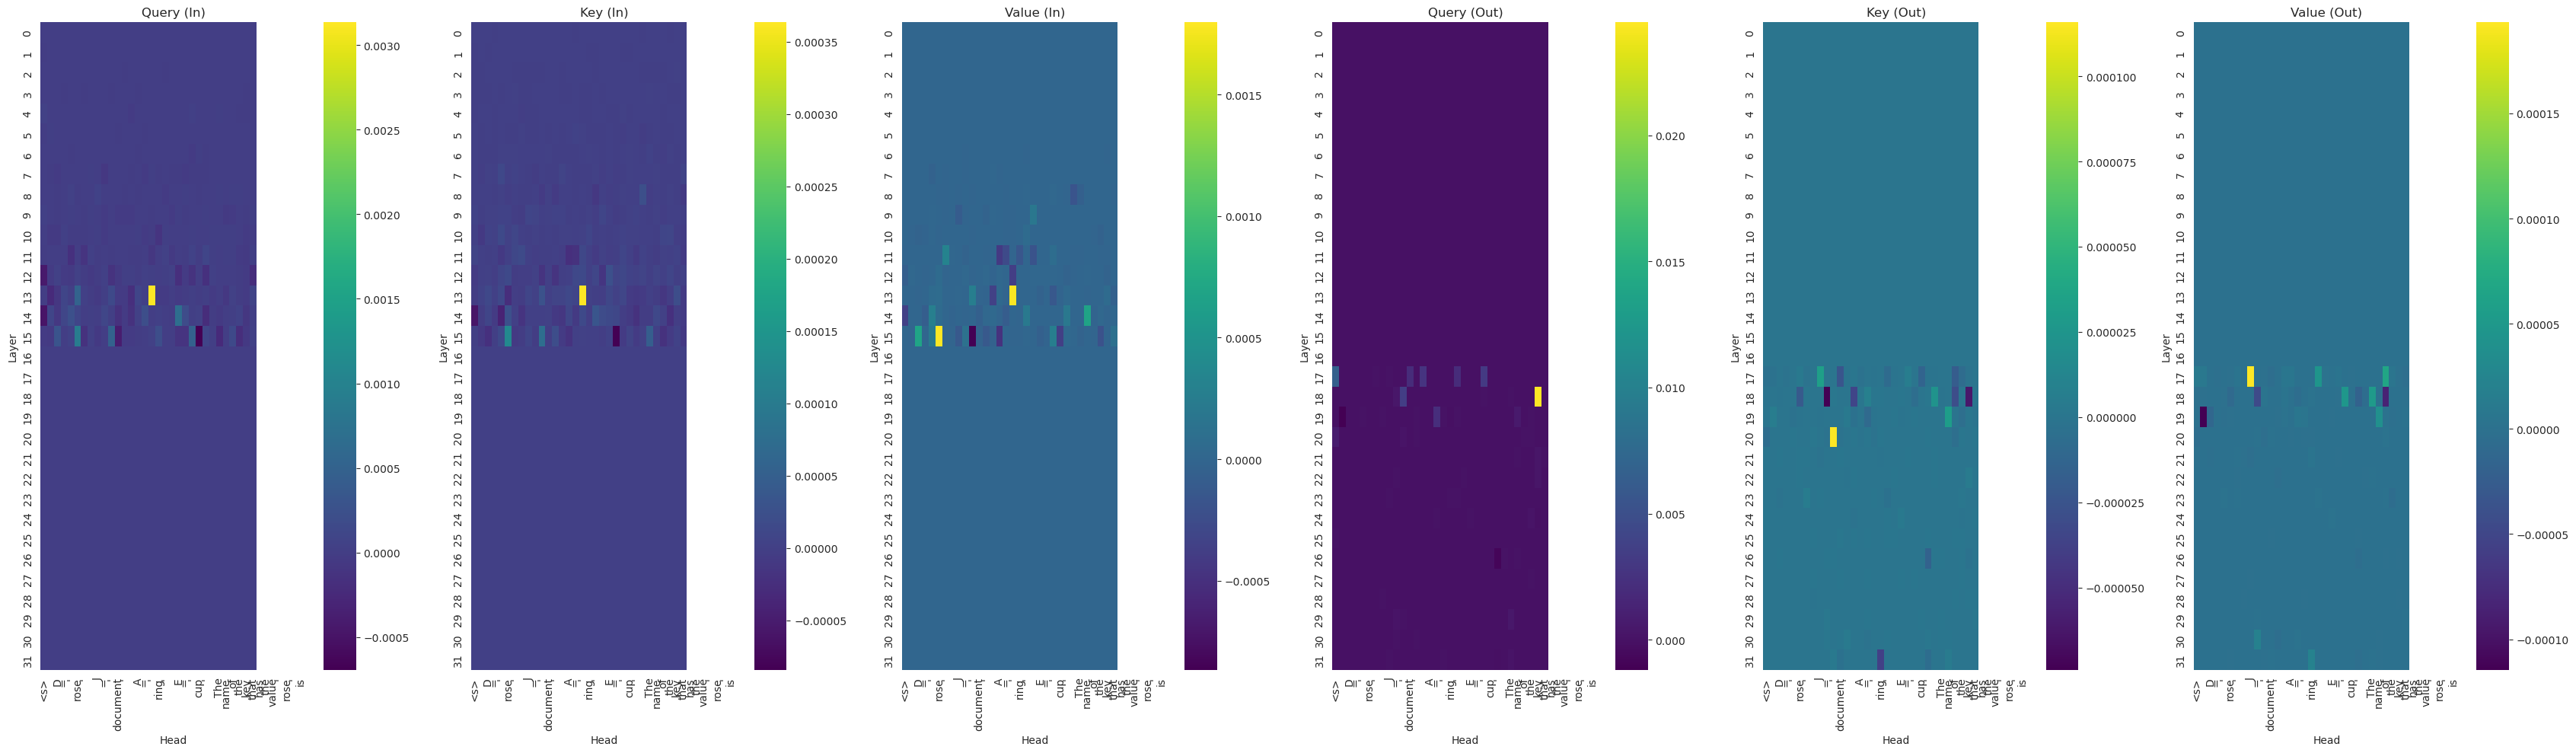

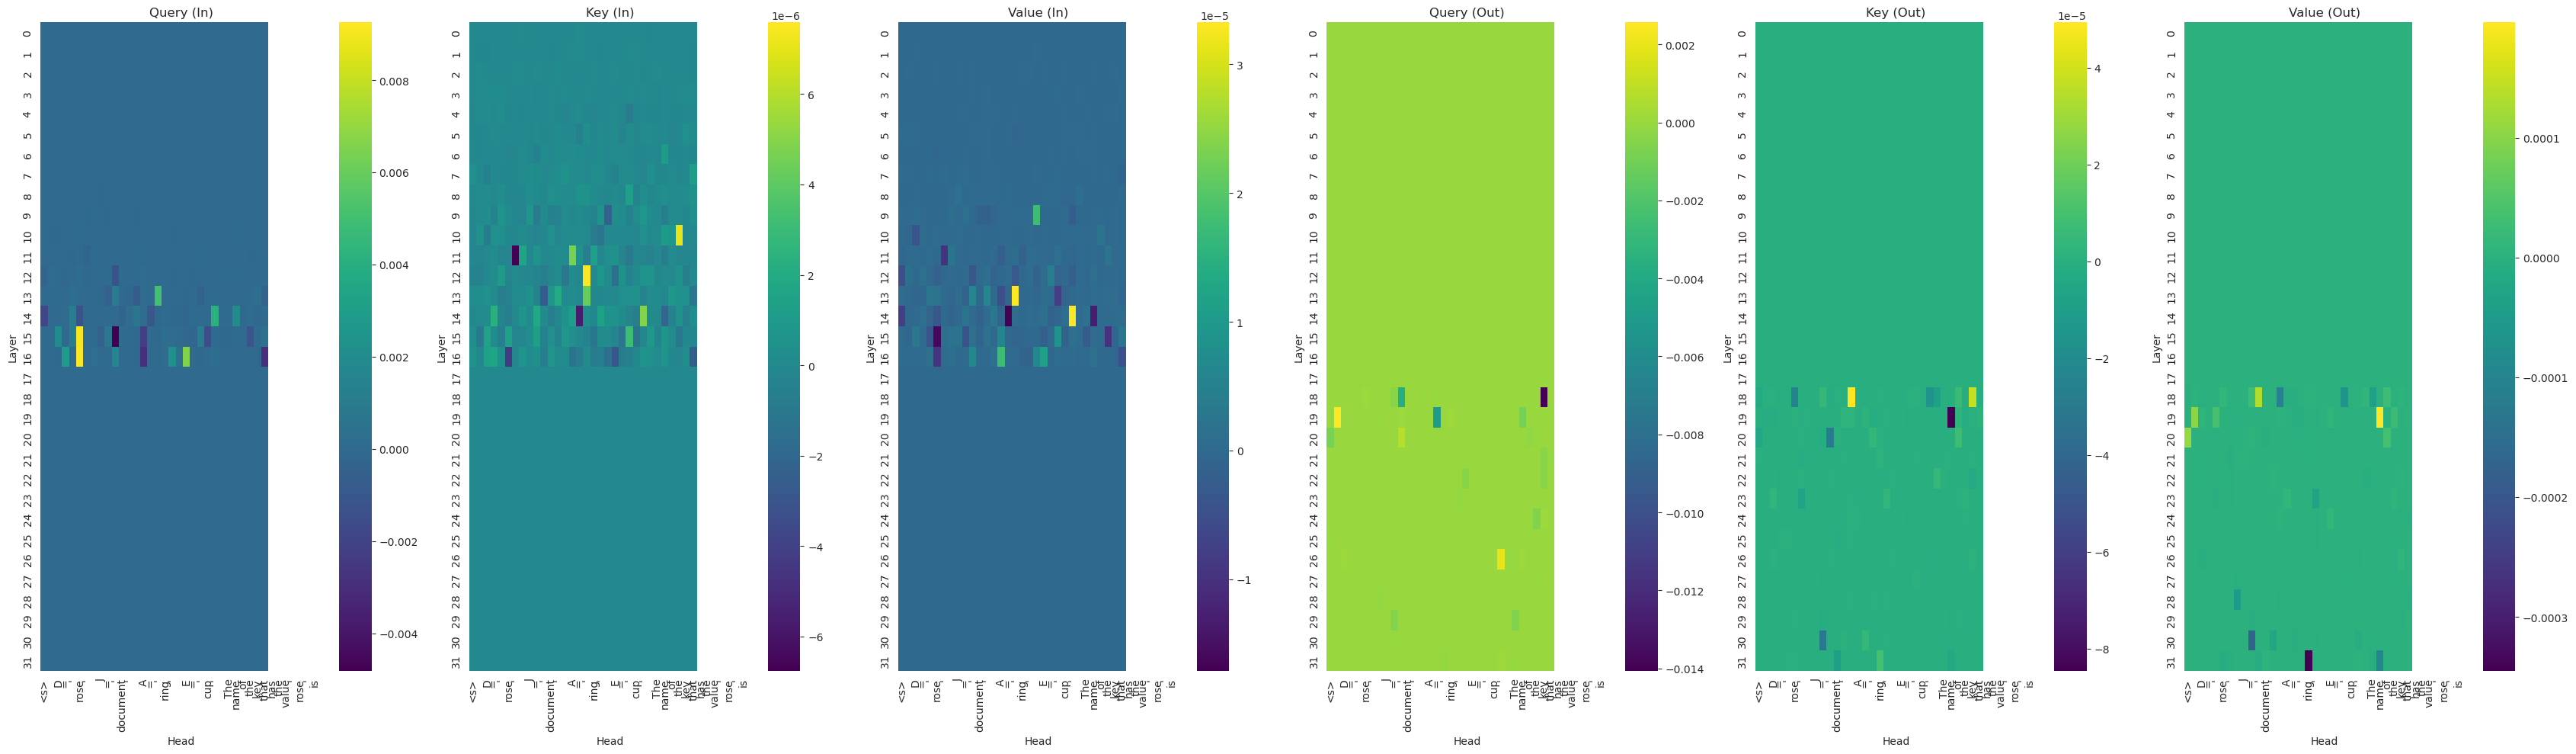

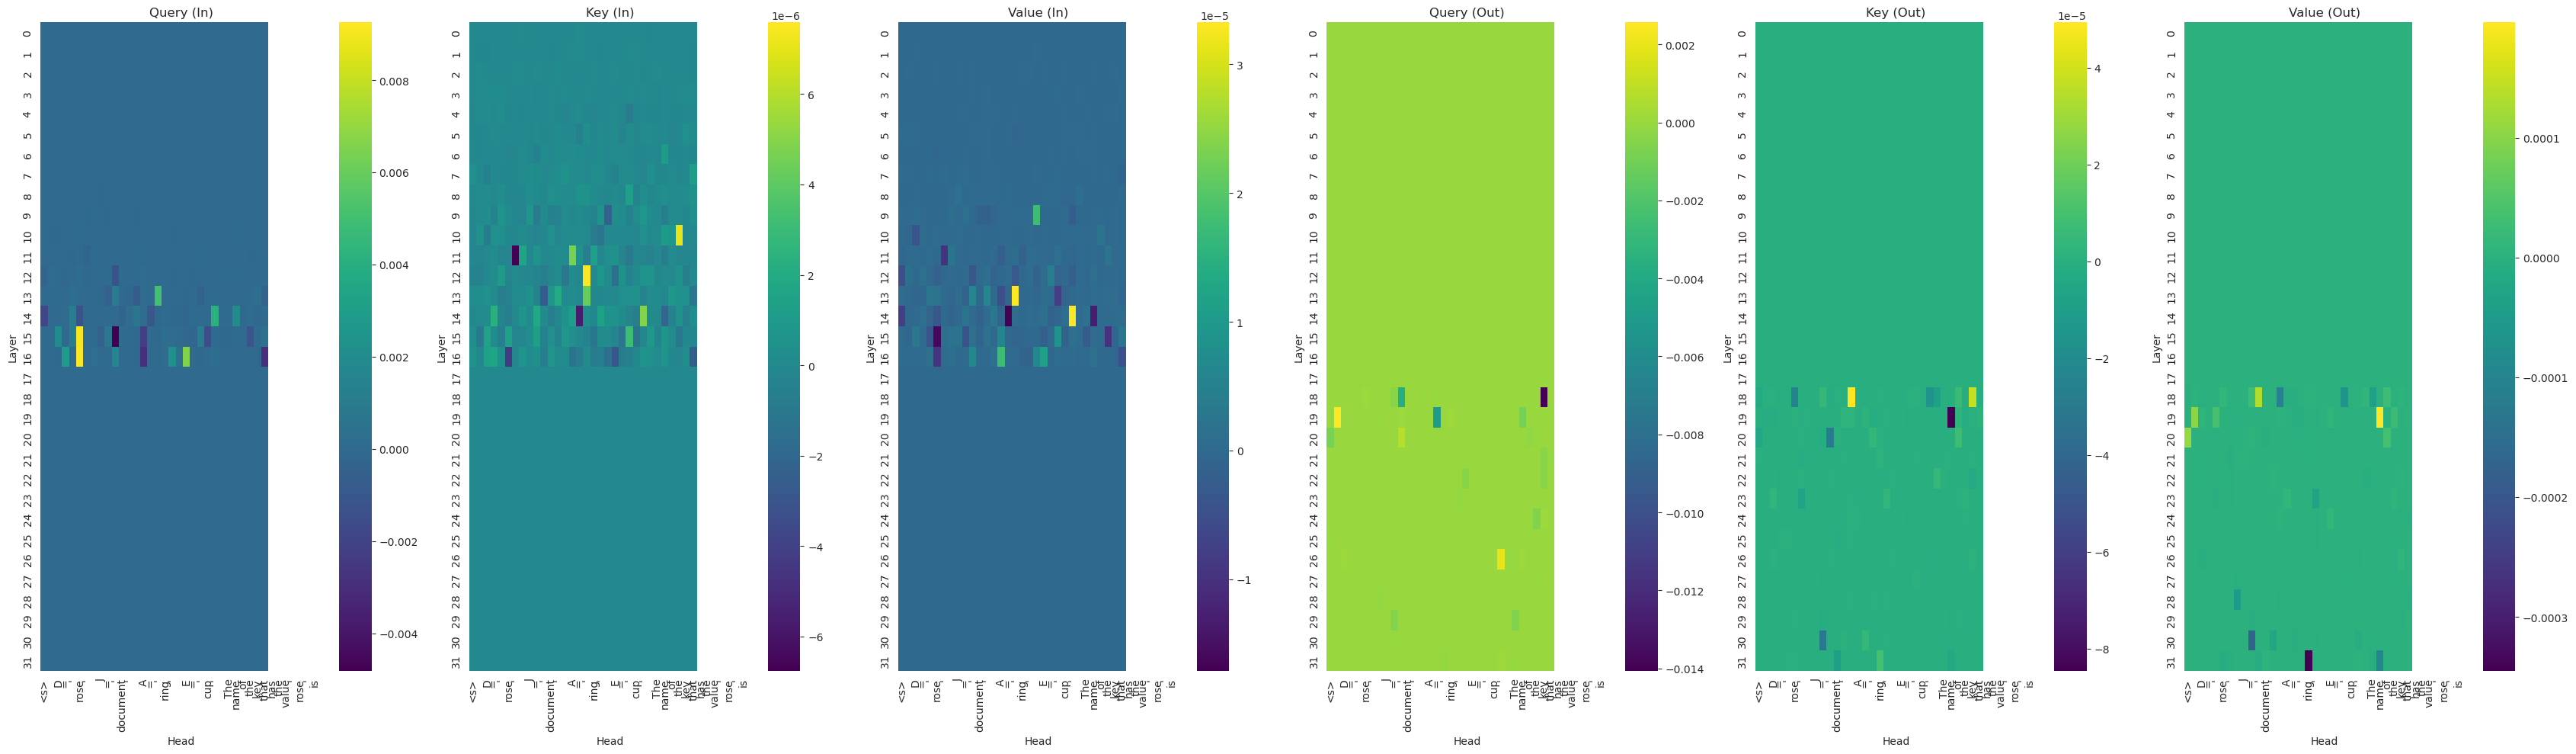

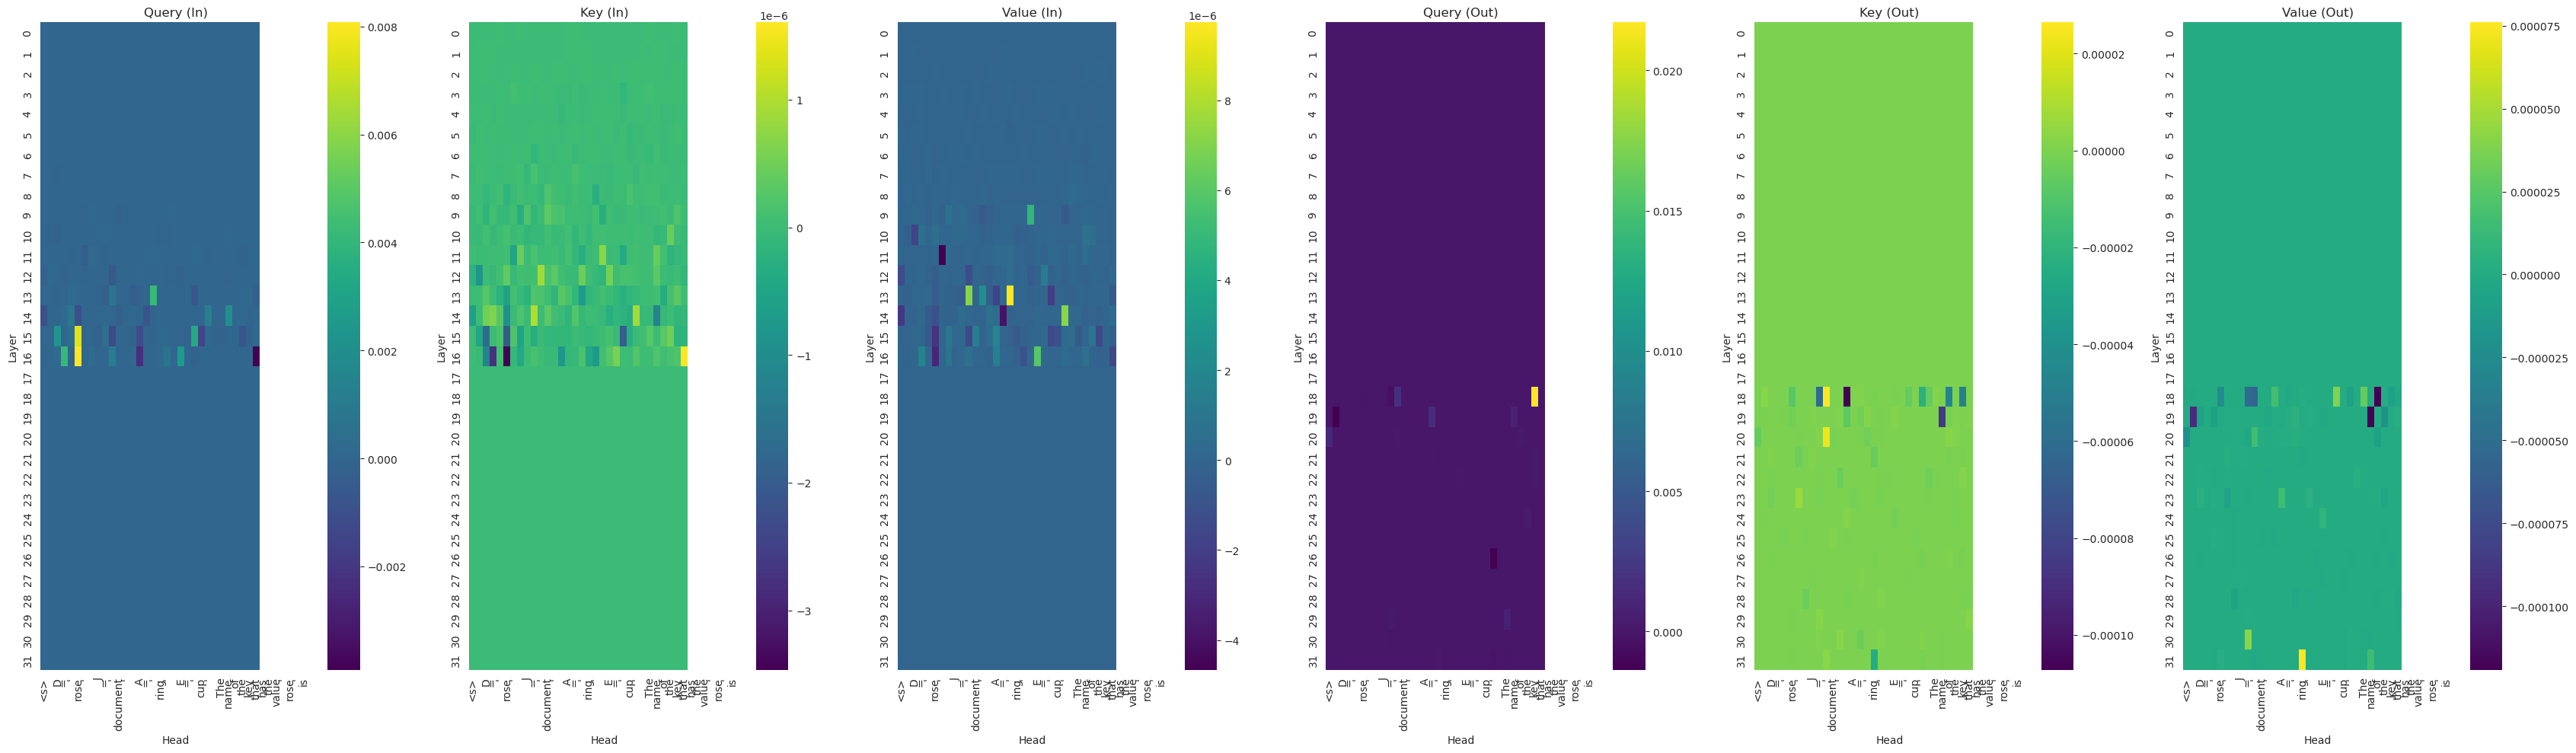

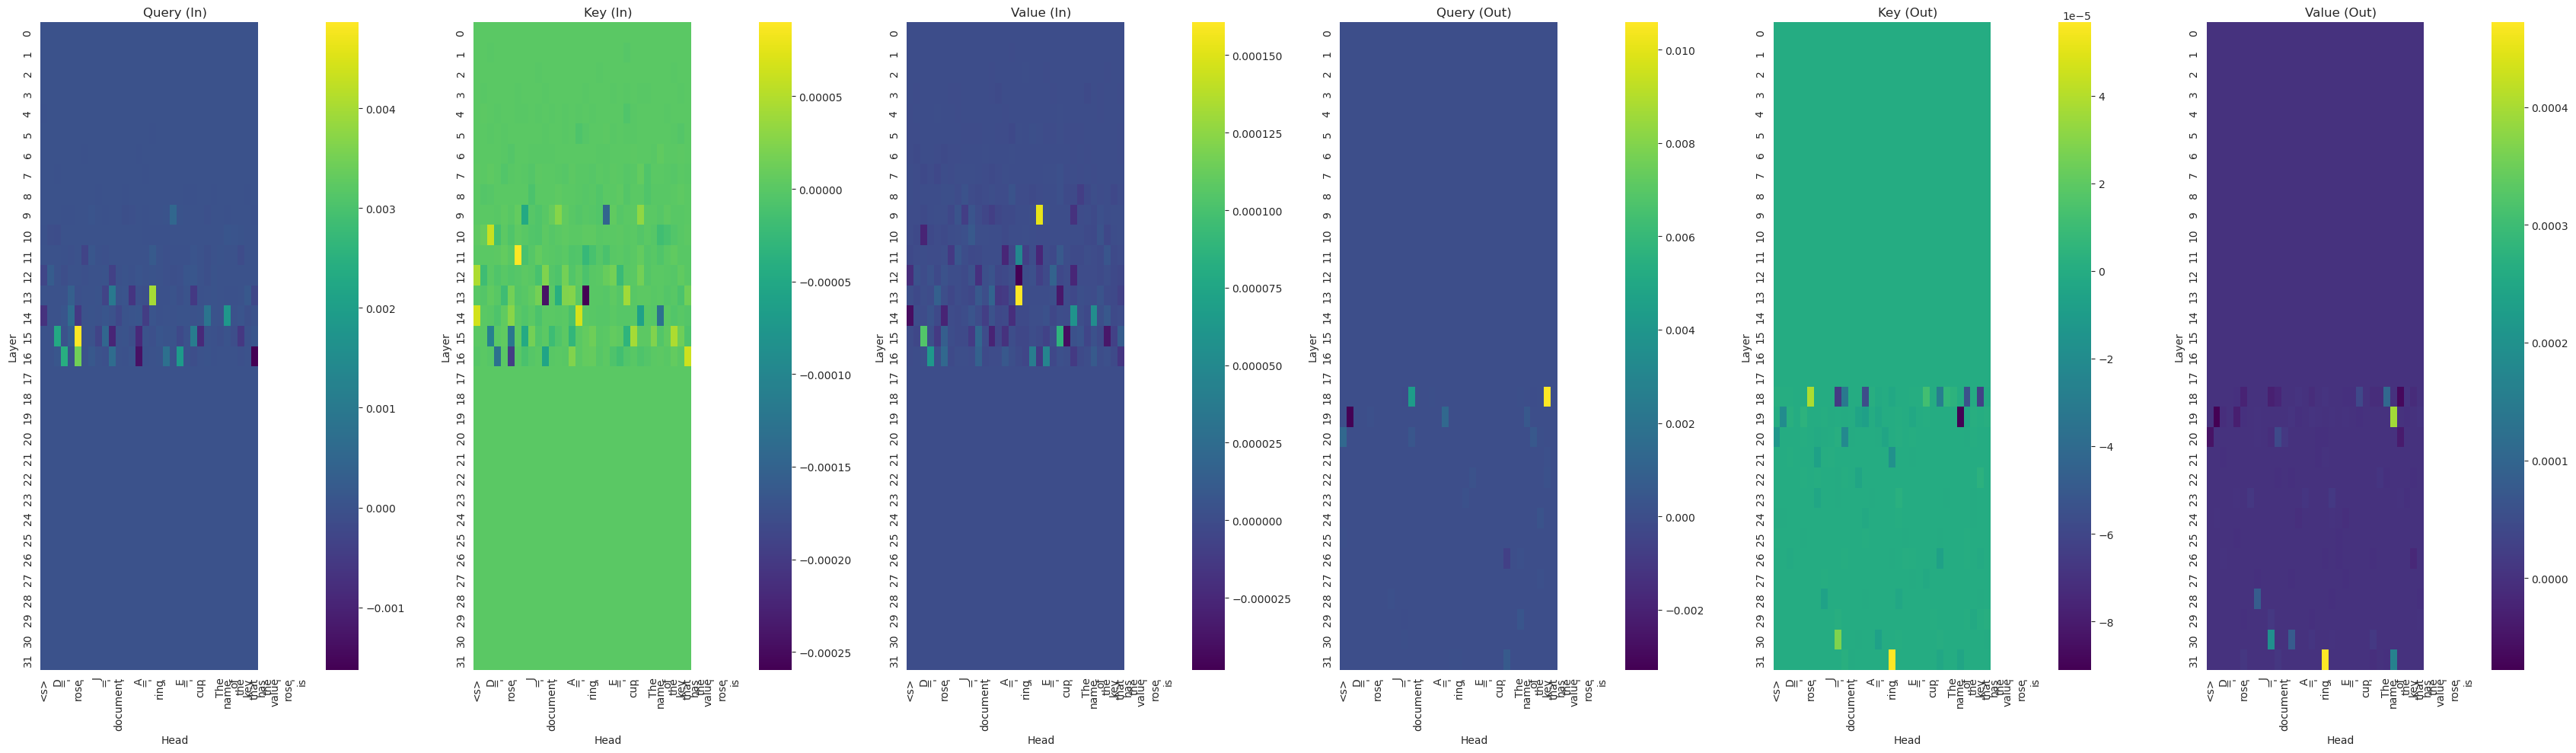

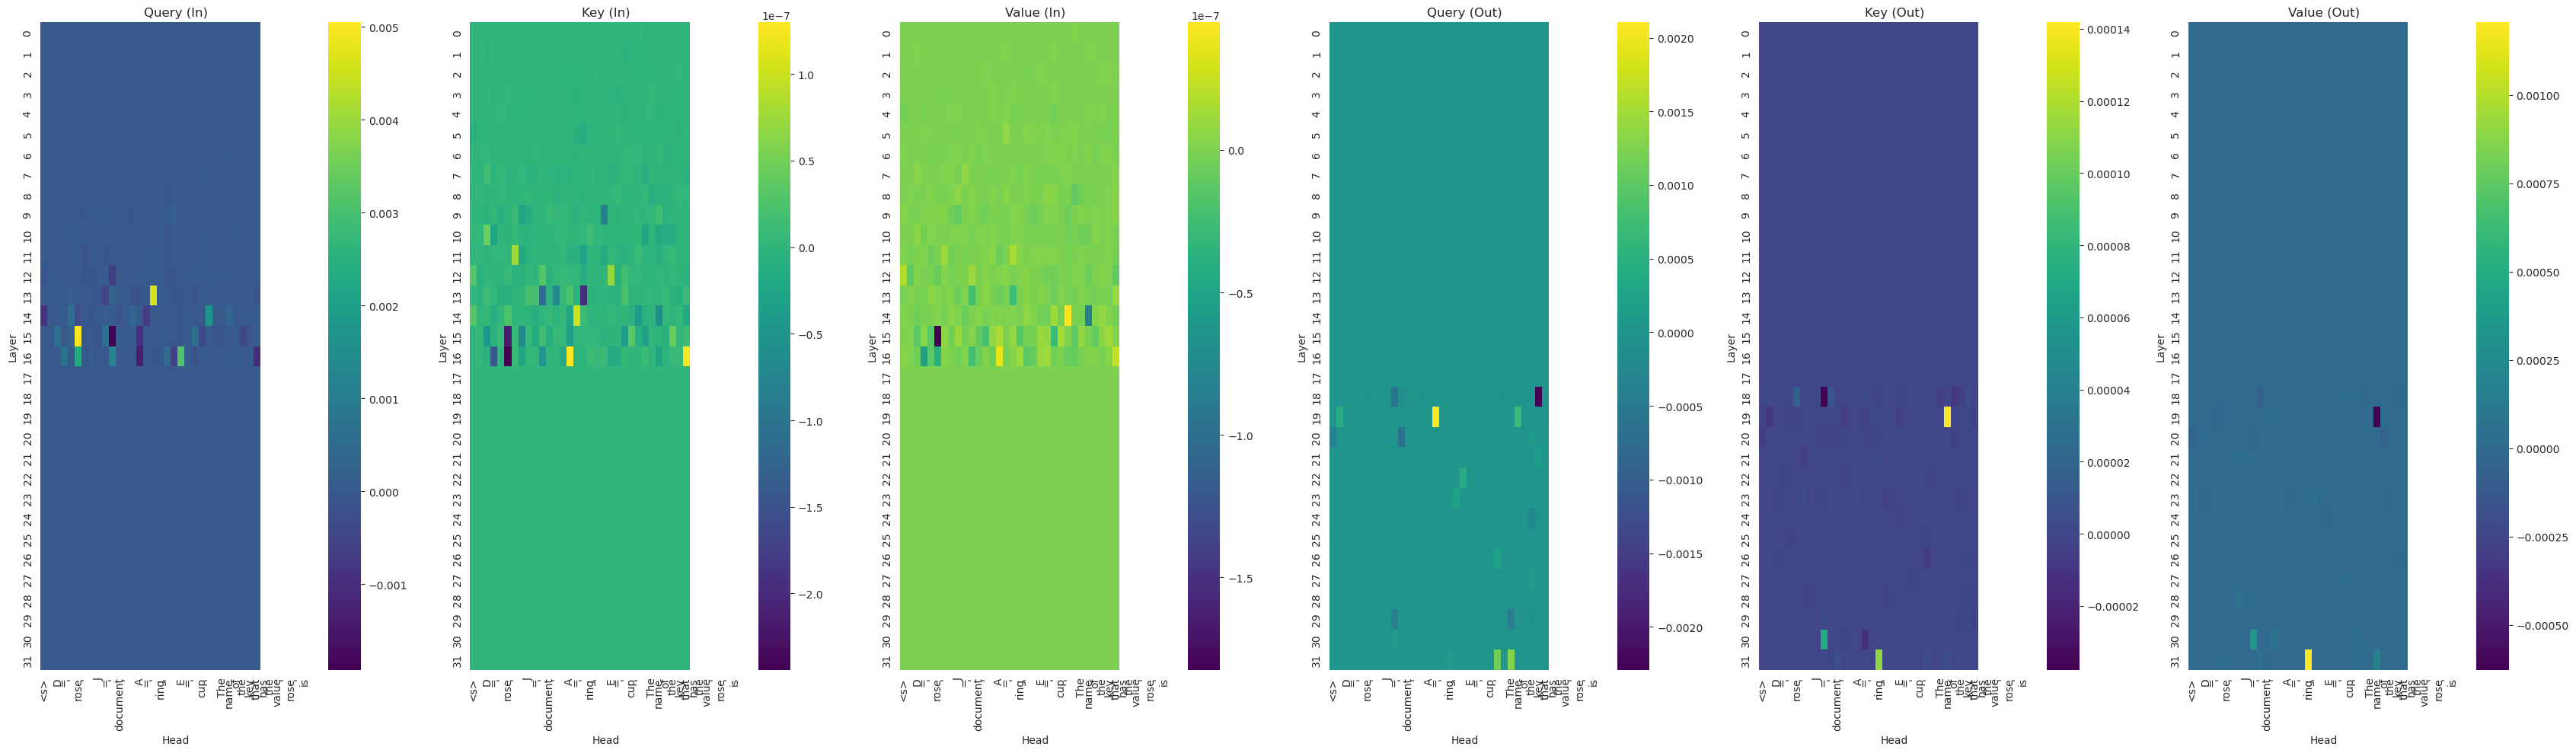

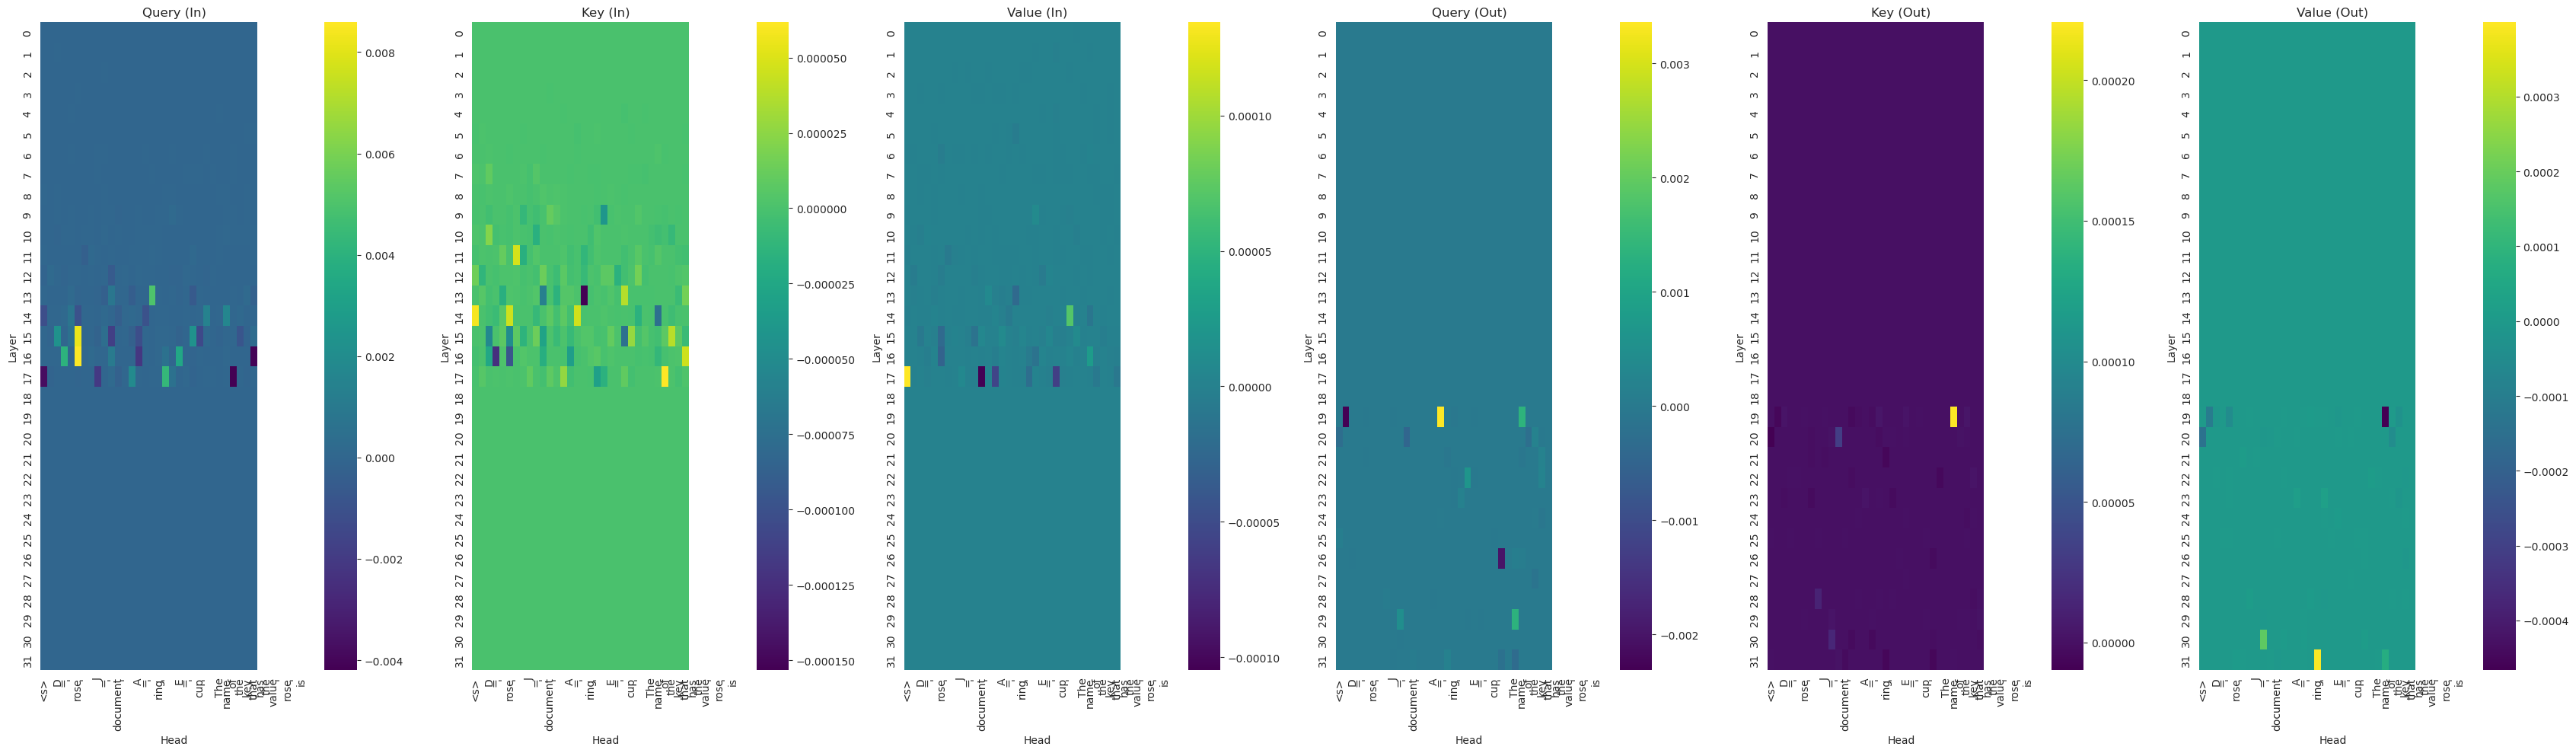

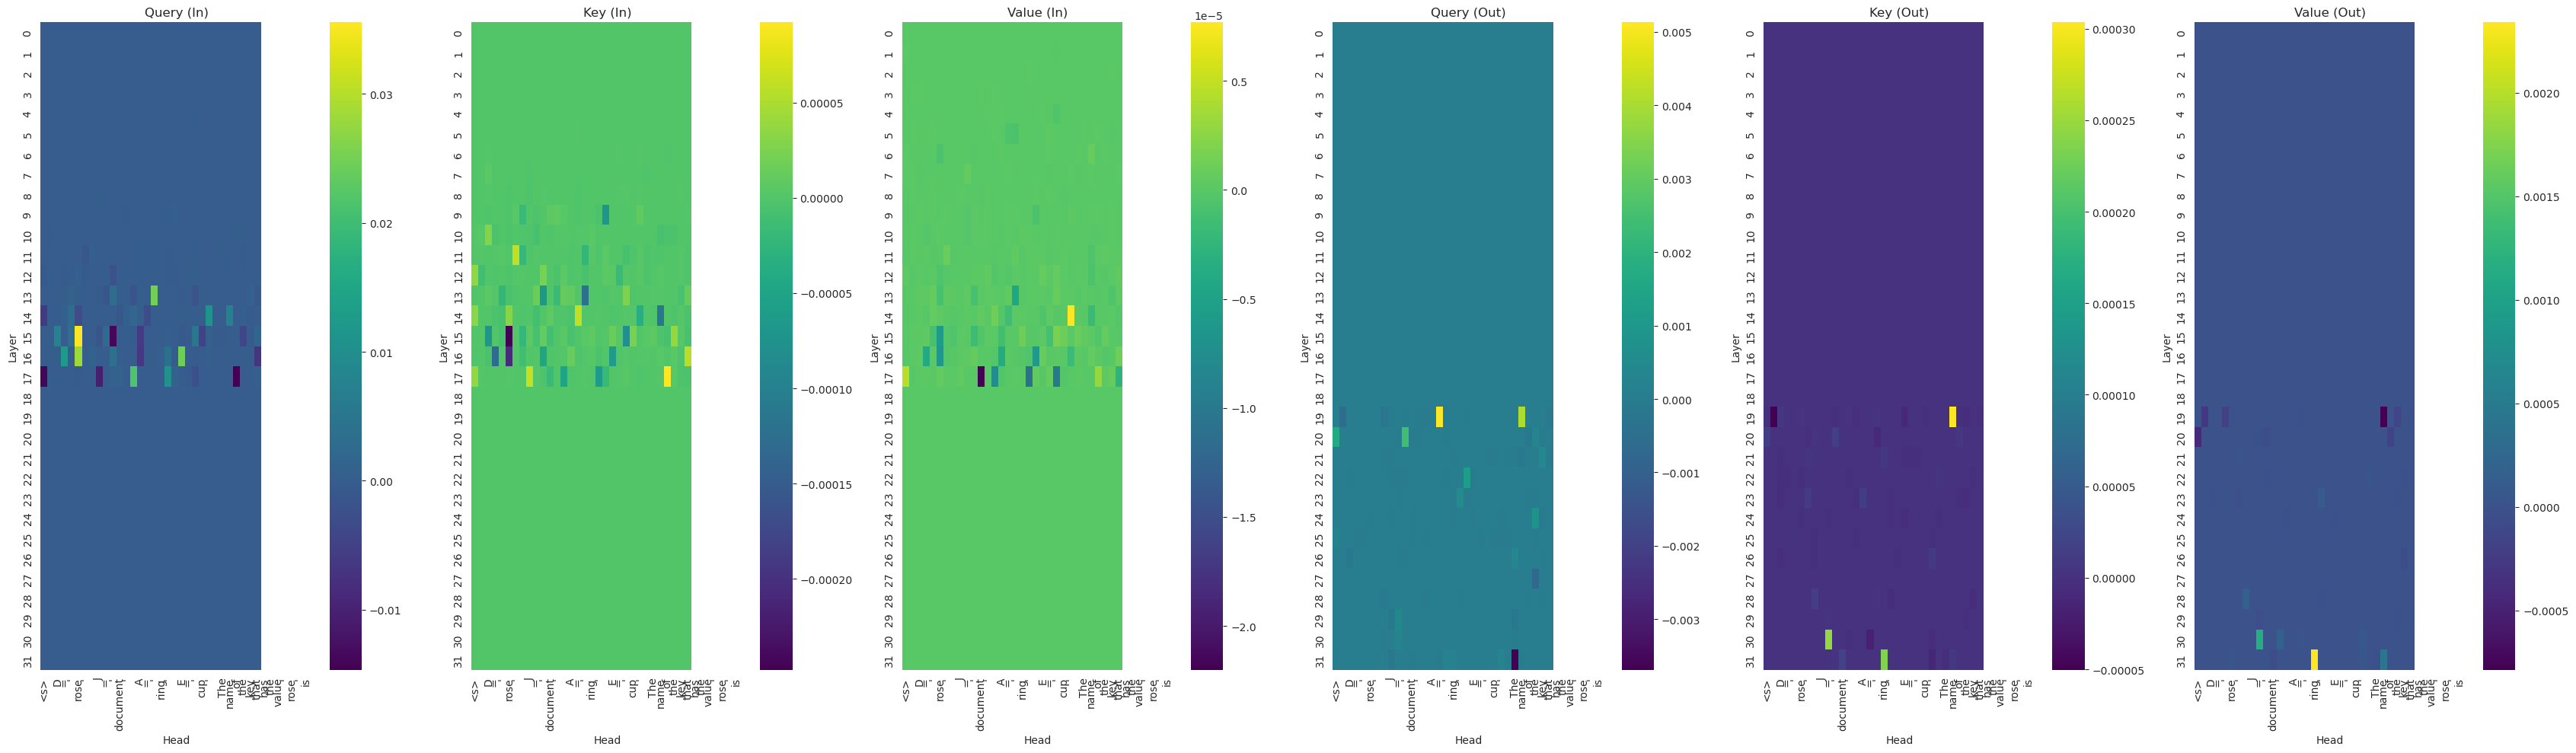

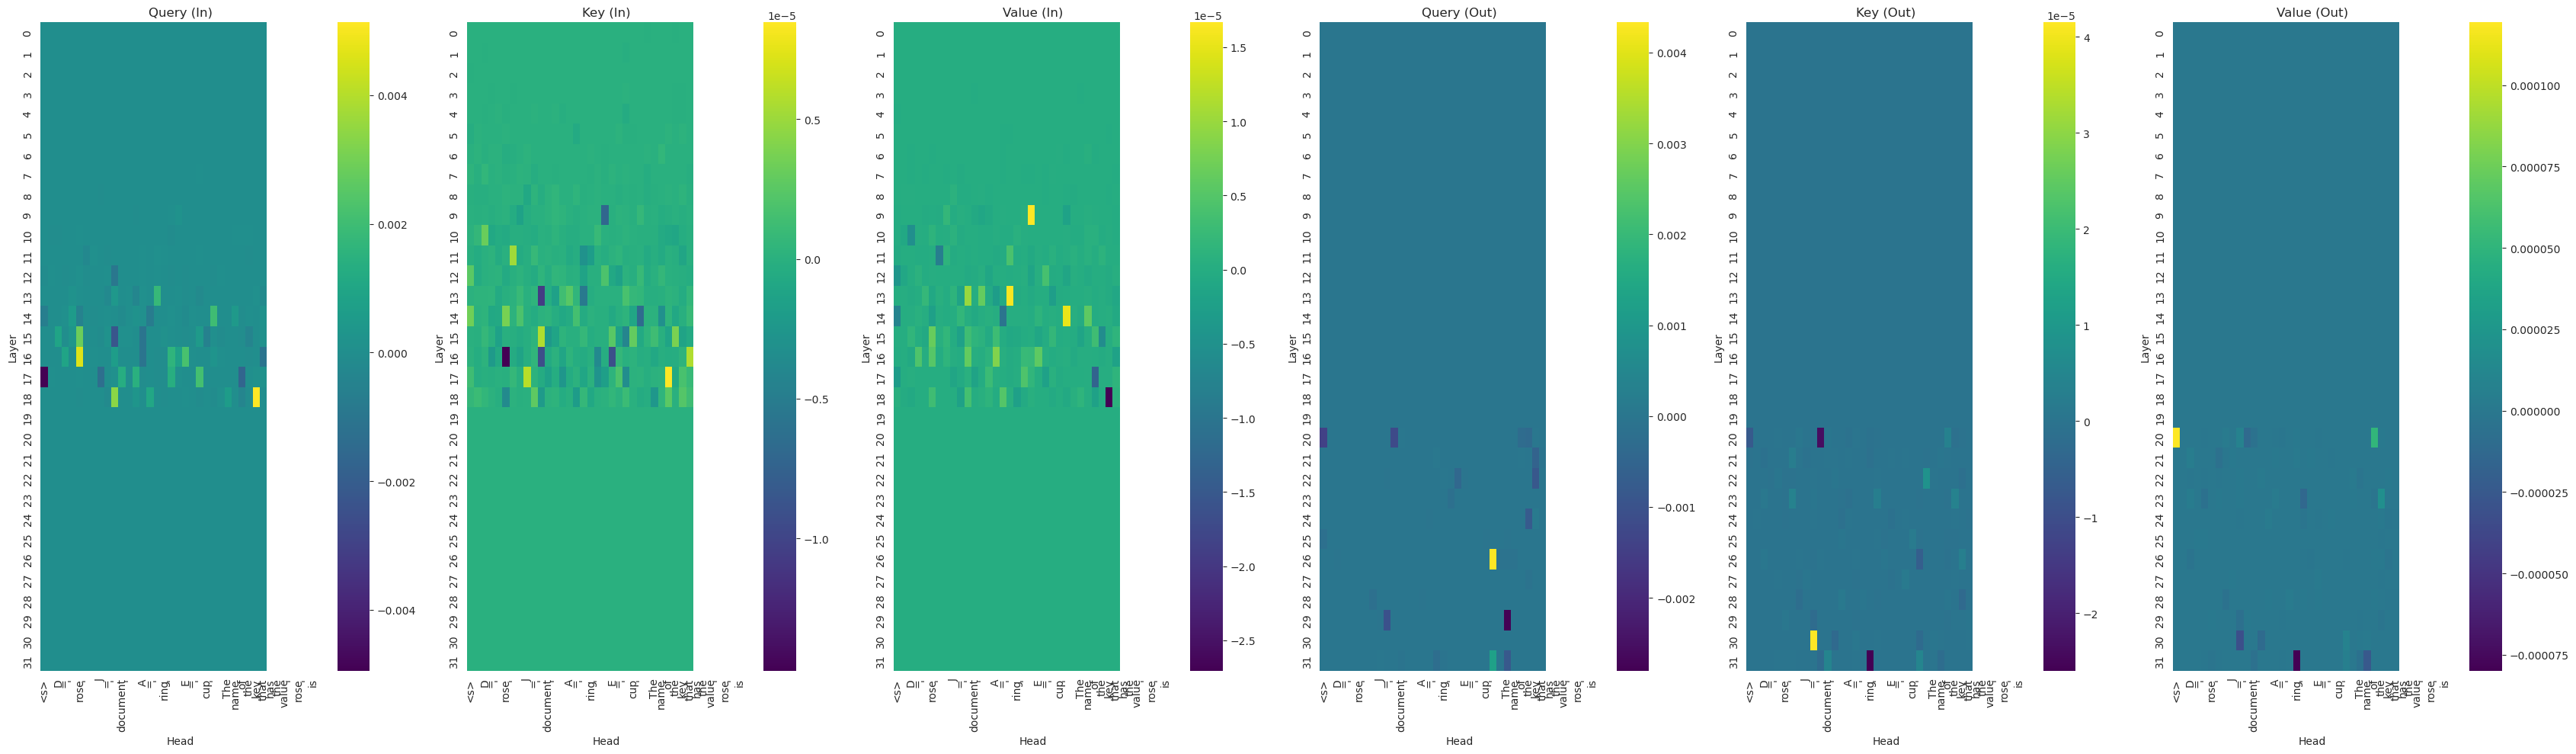

In [25]:

interesting_heads = [ #path start
    13 * model.cfg.n_heads + 16,
    15 * model.cfg.n_heads + 5,
    15 * model.cfg.n_heads + 10,
    16 * model.cfg.n_heads + 5,
    16 * model.cfg.n_heads + 20,
    17 * model.cfg.n_heads + 0,

    # path end 
    # 18 * model.cfg.n_heads + 30,
    17 * model.cfg.n_heads + 0,
    17 * model.cfg.n_heads + 13,
    17 * model.cfg.n_heads + 18,
    17 * model.cfg.n_heads + 22,
    18 * model.cfg.n_heads + 10,
    18 * model.cfg.n_heads + 30,
    19 * model.cfg.n_heads + 15,
]
interesting_head_labels = [HEAD_NAMES[i] for i in interesting_heads]
for head_index, label in zip(interesting_heads, interesting_head_labels):
    in_paths = head_path_attr[3 * head_index : 3 * head_index + 3].sum(-1)
    out_paths = head_path_attr[:, head_index].sum(-1)
    out_paths = einops.rearrange(out_paths, "(layer_head qkv) -> qkv layer_head", qkv=3)
    all_paths = torch.cat([in_paths, out_paths], dim=0)
    all_paths = einops.rearrange(
        all_paths,
        "path_type (layer head) -> path_type layer head",
        layer=model.cfg.n_layers,
        head=model.cfg.n_heads,
    )
    fig, axs = plt.subplots(1,6, figsize=(34, 10))
    facet_labels=["Query (In)",
            "Key (In)",
            "Value (In)",
            "Query (Out)",
            "Key (Out)",
            "Value (Out)",
        ]

    for i in range(6):
        fig = sns.heatmap(all_paths.cpu().detach().numpy()[i], ax = axs[i], xticklabels= model.to_str_tokens(clean_tokens[0]), cmap='viridis')
        axs[i].set_title(facet_labels[i])
        axs[i].set_xlabel('Head')
        axs[i].set_ylabel('Layer')

    plt.tight_layout()
    plt.savefig(f'plots/interestingHeads_{head_index}_{label}_attribution_patching.png')
# TODO - implement visualization for input/output paths per head


check_gpu_memory()

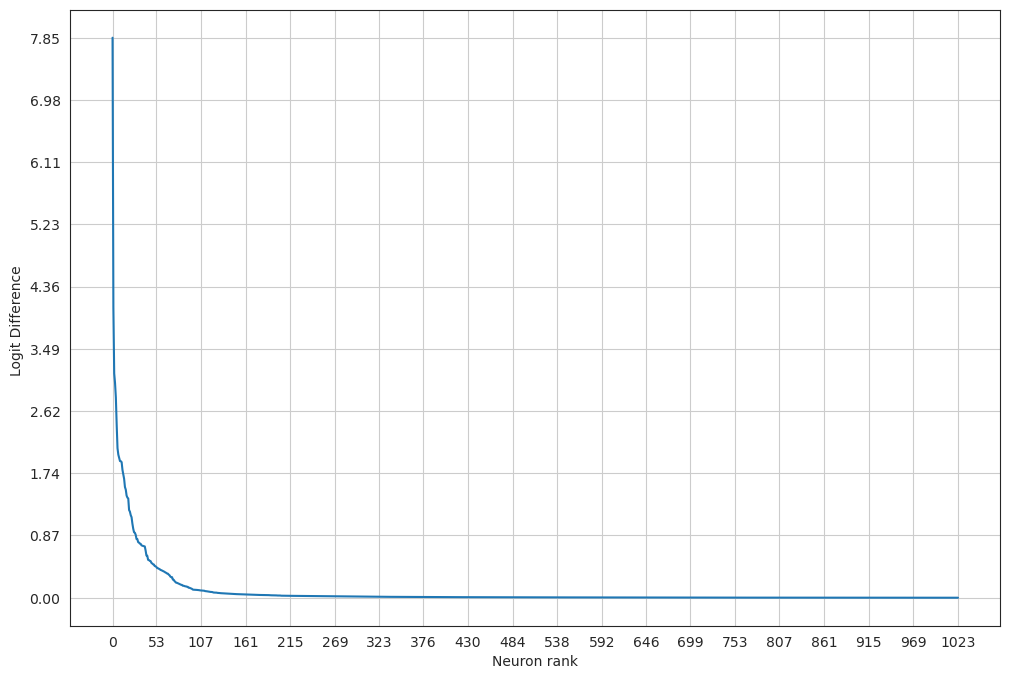

In [12]:


# Assuming head_out_values is a tensor
head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
top_head_indices = head_out_indices[:40].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

# Convert head_out_values to numpy array for plotting
head_out_values_np = head_out_values.detach().numpy()

# Define the number of ticks you want
num_ticks_x = 20
num_ticks_y = 10

# Generate tick positions and labels for x-axis and y-axis
x_ticks = np.linspace(0, len(head_out_values_np) - 1, num_ticks_x, dtype=int)
y_ticks = np.linspace(min(head_out_values_np), max(head_out_values_np), num_ticks_y)

plt.figure(figsize=(12, 8))
plt.xlabel('Neuron rank')
plt.ylabel('Logit Difference ')
# plt.title('Head Path Attribution Patching')

plt.plot(head_out_values_np)

# Set x and y ticks
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, [f'{ytick:.2f}' for ytick in y_ticks])

plt.grid(True)
plt.show()


In [25]:
head_out_attr[:, -1].shape

torch.Size([1024])

In [29]:
head_path_attr[top_end_indices, :][:, top_start_indices].shape

torch.Size([105, 35, 40])

Primary device: cuda:0
GPU 0: 81050.62 MB  Allocated: 52073.22 MB  Reserved: 52192.00 MB


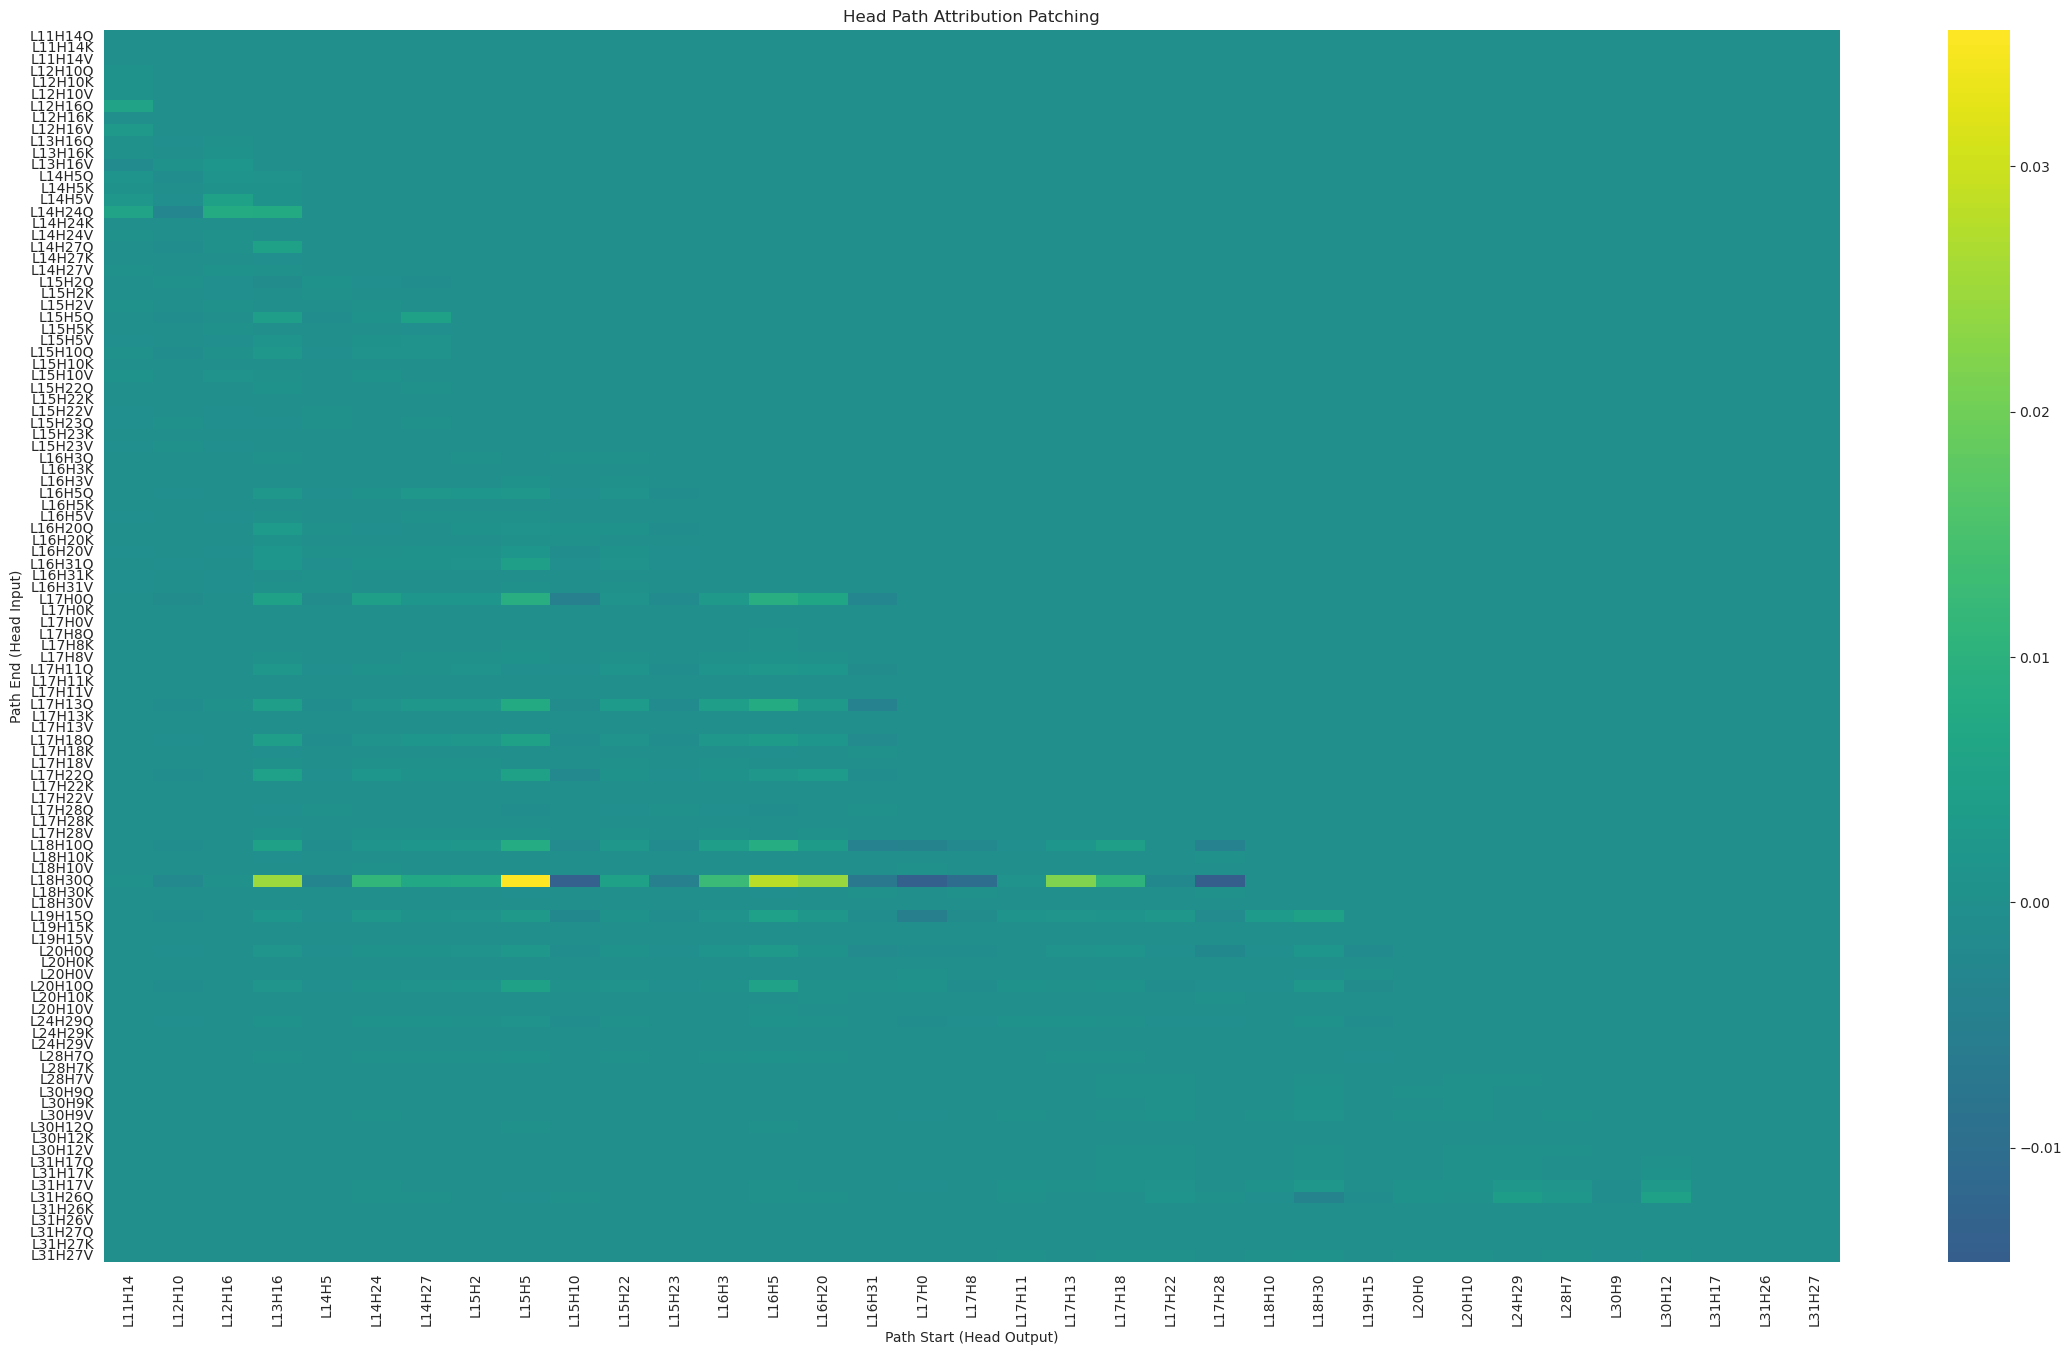

In [56]:



# head_path_attr, end_labels, start_labels = attr_patch_head_path(
#     clean_cache_first, corrupted_cache_first, corrupted_grad_cache_first, "cpu"
# )


# plt.figure(figsize=(32, 12))
# sns.set_style("white")
# sns.heatmap(head_path_attr.sum(-1).detach().numpy(), yticklabels=end_labels, xticklabels = start_labels, annot=False, cmap='viridis', center=0)
# plt.yticks(fontsize = 5)
# plt.xlabel('Path Start (Head Output)')
# plt.ylabel('Path End (Head Input)')
# plt.title('Head Path Attribution Patching')
# plt.savefig('plots/head_path_attribution_patching.png')
# top_head_path_attr = einops.rearrange(
#     head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1),
#     "(head_end qkv) head_start -> qkv head_end head_start",
#     qkv=3,
# )


#head_out_values, head_out_indices = head_out_attr[:, 17].abs().sort(descending=True) 
head_out_values, head_out_indices = head_out_attr.sum(-1).abs().sort(descending=True)
top_head_indices = head_out_indices[:35].sort().values
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

# plt.plot(head_out_values.detach().numpy())

for i in top_head_indices:
    i = i.item()
    top_start_indices.append(i)
    top_start_labels.append(start_labels[i])
    for j in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])



check_gpu_memory()

plt.figure(figsize=(28, 16))
# sns.heatmap(head_path_attr[top_end_indices, :][:, top_start_indices][:, :, 17].detach().numpy(), yticklabels = top_end_labels, xticklabels= top_start_labels, annot=False, cmap='viridis', center=0)
sns.heatmap(head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1).detach().numpy(), yticklabels = top_end_labels, xticklabels= top_start_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching')
plt.savefig('plots/head_path_2_attribution_patching.png')


Threshold: 0.0014606665790779516
Indices of paths with absolute correlation values greater than the threshold:
[(6, 0), (15, 0), (15, 2), (15, 3), (48, 3), (48, 8), (48, 13), (48, 14), (57, 8), (57, 13), (63, 8), (69, 3), (69, 8), (69, 13), (72, 3), (72, 5), (72, 6), (72, 7), (72, 8), (72, 9), (72, 12), (72, 13), (72, 14), (72, 15), (72, 16), (72, 17), (72, 19), (72, 20), (72, 22), (75, 24), (81, 8), (81, 13)]


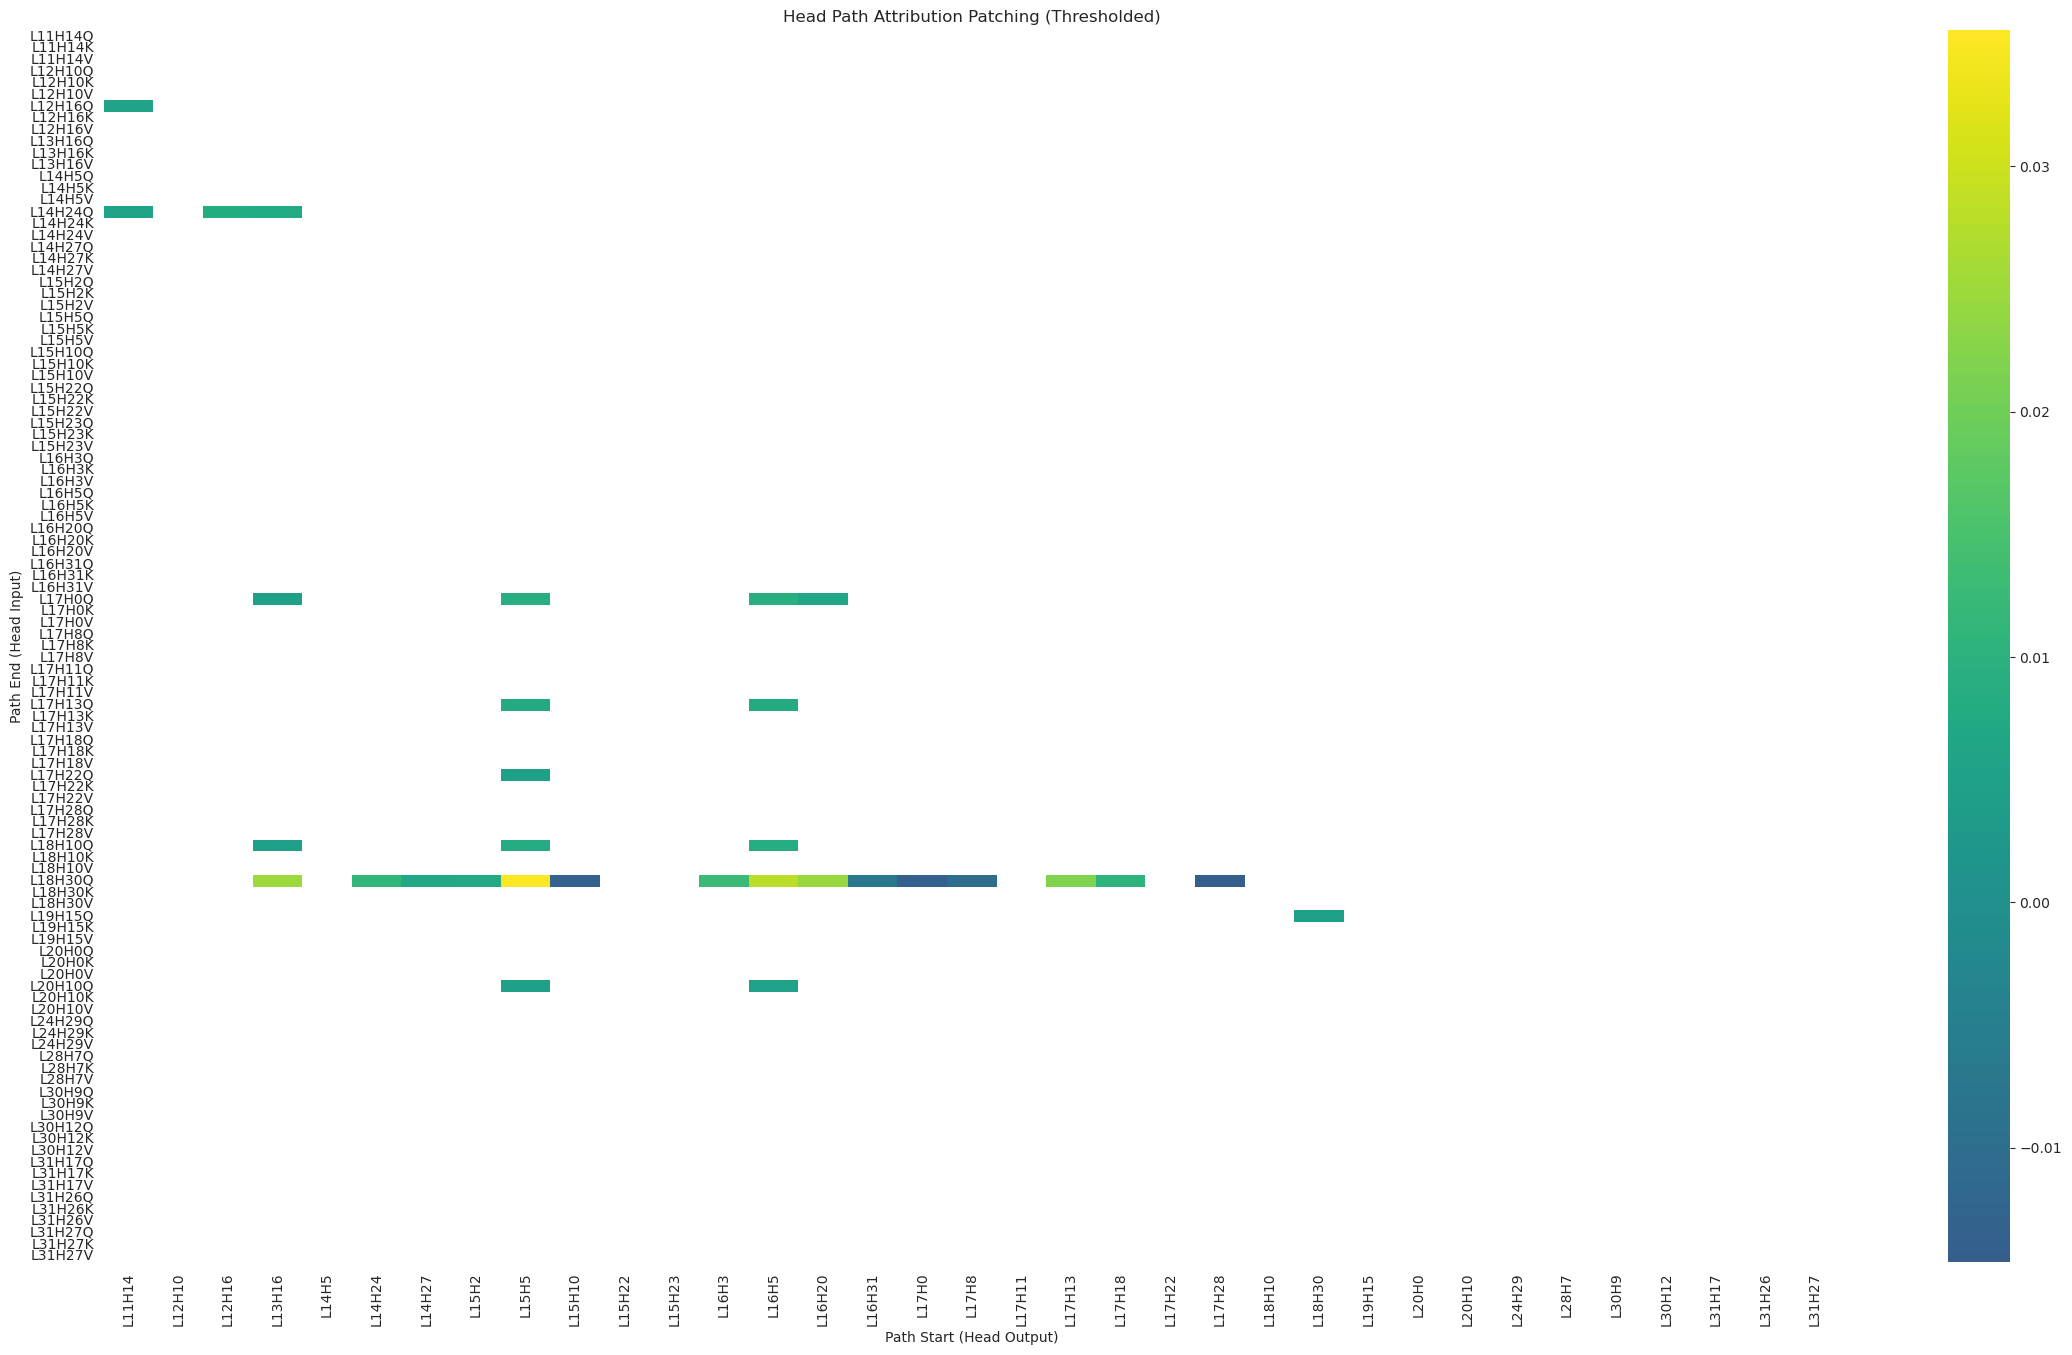

In [15]:

# Calculate the sum over the last dimension to get the correlation values
correlation_values = head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1)

# Calculate mean and standard deviation
mean_value = correlation_values.mean().item()
std_dev = correlation_values.std().item()

# Define the threshold as mean + std_dev
threshold = mean_value + std_dev

# Calculate the absolute values of the correlation matrix
abs_correlation_values = correlation_values.abs()

# Create a boolean mask where absolute values are greater than the threshold
mask = abs_correlation_values > 0.005 #threshold

# Get the indices where the condition is met
indices = mask.nonzero(as_tuple=True)

# Convert indices to a list of tuples
path_indices = list(zip(indices[0].tolist(), indices[1].tolist()))

print(f"Threshold: {threshold}")
print("Indices of paths with absolute correlation values greater than the threshold:")
print(path_indices)

# Create a new matrix for plotting with values above the threshold
thresholded_matrix = correlation_values.clone()
thresholded_matrix[~mask] = np.nan  # Set values not meeting the threshold to NaN for better heatmap visualization

# Plotting the heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(thresholded_matrix.detach().numpy(), yticklabels=top_end_labels, xticklabels=top_start_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching (Thresholded)')
# plt.savefig('plots/head_path_2_attribution_patching_thresholded.png')
plt.show()

Threshold: 5.225775926476217e-05
Indices of paths with absolute correlation values greater than the threshold:
[(1200, 358), (1200, 366), (1211, 366), (1224, 358), (1225, 358), (1225, 366), (1226, 366), (1416, 358), (1416, 366), (1416, 400), (1416, 432), (1580, 485), (1632, 432), (1632, 485), (1632, 517), (1632, 532), (1671, 485), (1671, 517), (1698, 485), (1758, 432), (1758, 485), (1758, 517), (1818, 432), (1818, 448), (1818, 472), (1818, 475), (1818, 482), (1818, 485), (1818, 490), (1818, 494), (1818, 515), (1818, 517), (1818, 526), (1818, 532), (1818, 543), (1818, 544), (1818, 552), (1818, 557), (1818, 562), (1818, 572), (1869, 606), (1950, 485), (1950, 517)]


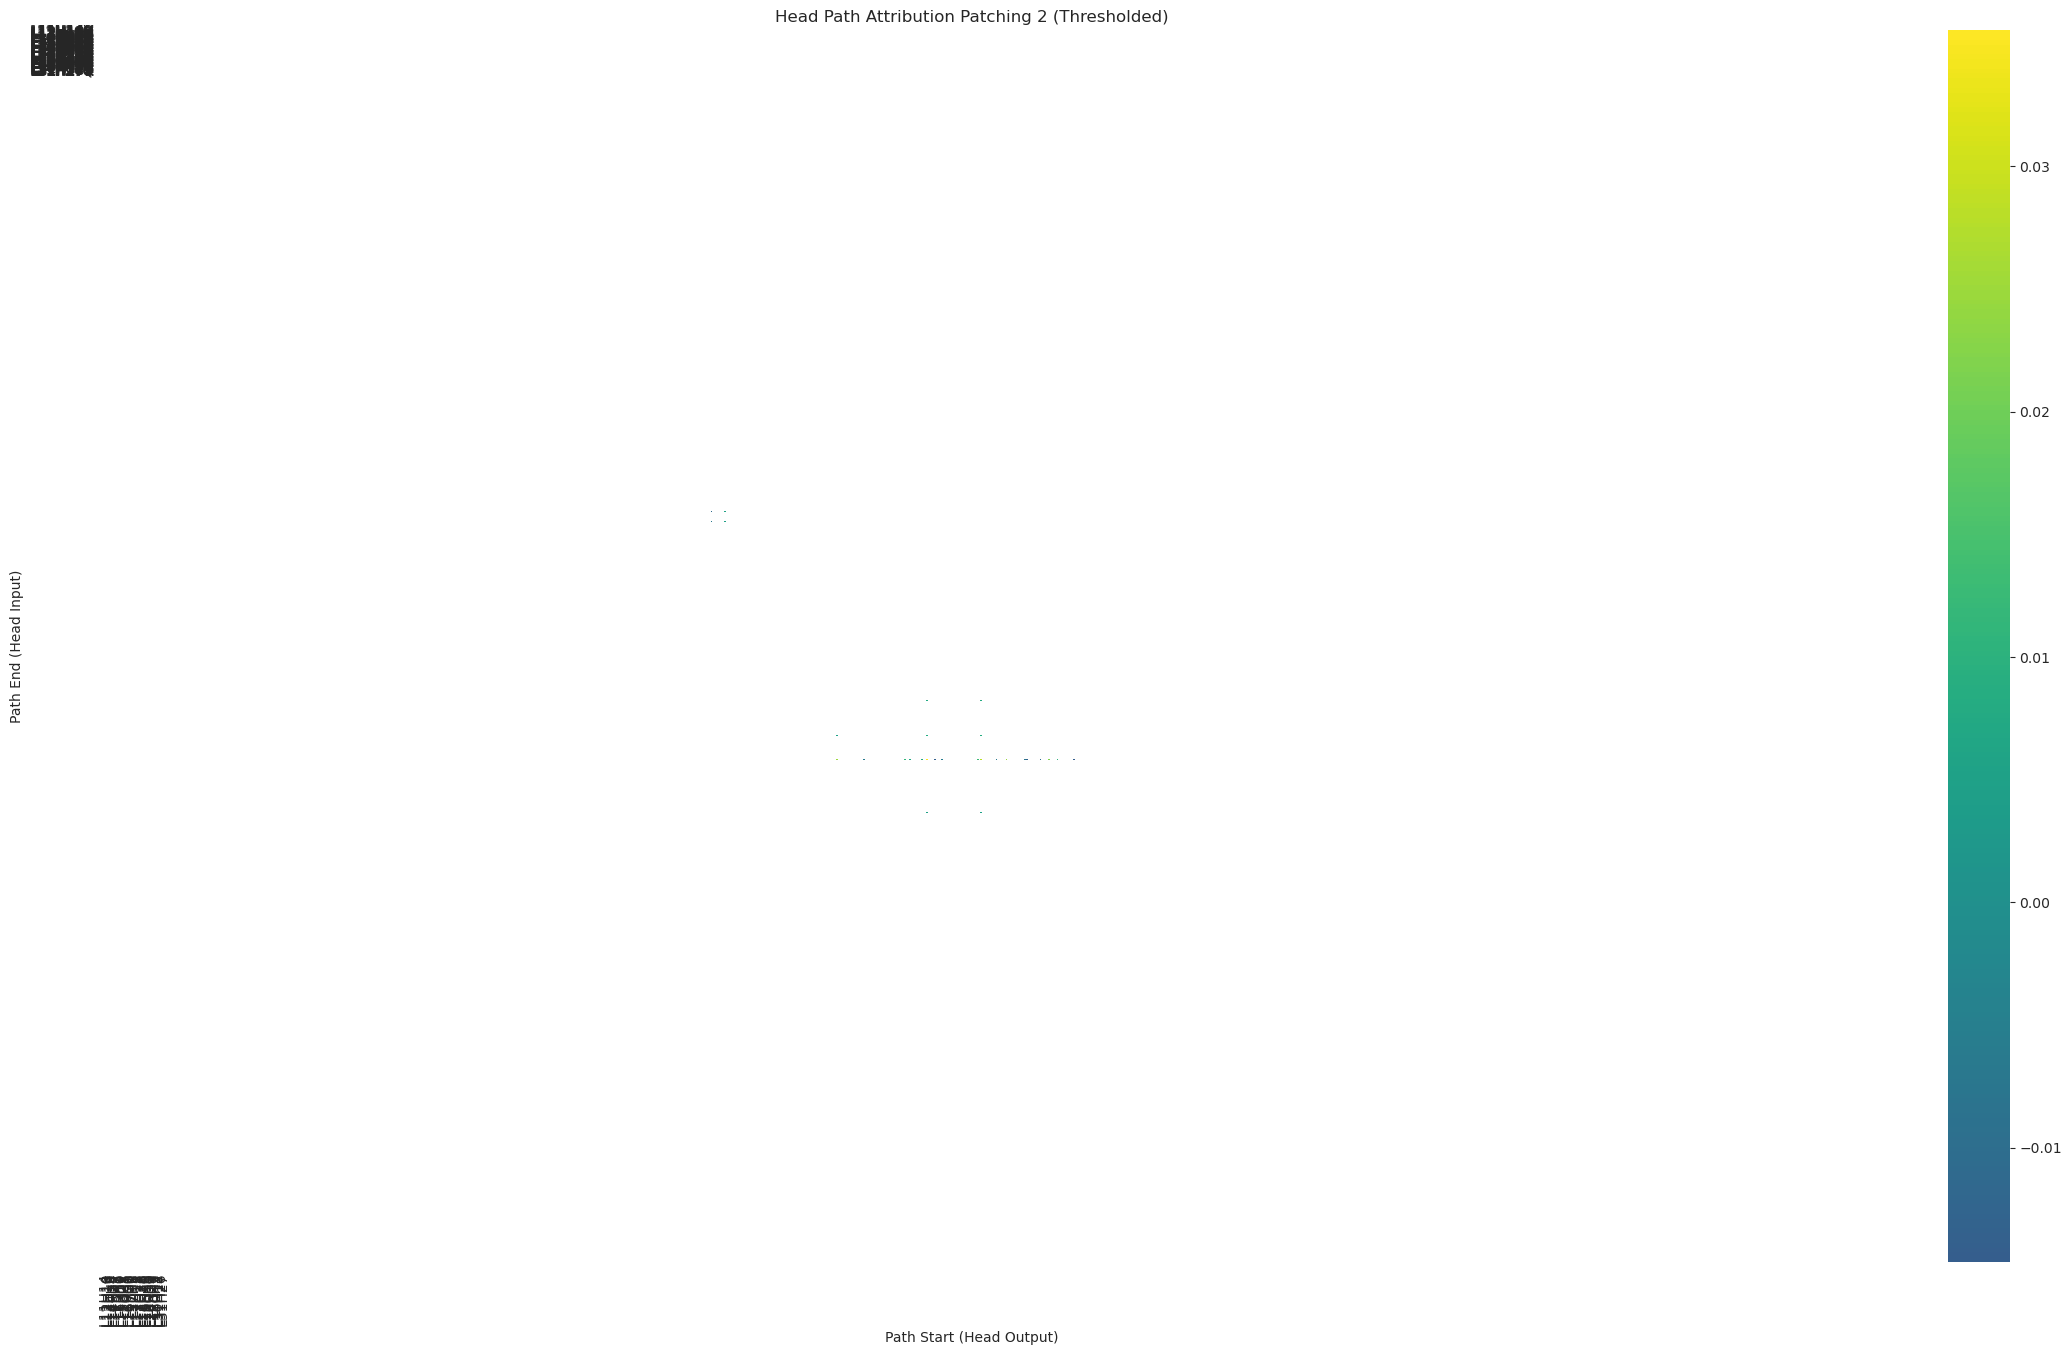

In [57]:
# Calculate the sum over the last dimension to get the correlation values
correlation_values = head_path_attr.sum(-1)

# Calculate mean and standard deviation
mean_value = correlation_values.mean().item()
std_dev = correlation_values.std().item()

# Define the threshold as mean + std_dev
threshold = mean_value + std_dev

# Calculate the absolute values of the correlation matrix
abs_correlation_values = correlation_values.abs()

# Create a boolean mask where absolute values are greater than the threshold
mask = abs_correlation_values > 0.005 #threshold

# Get the indices where the condition is met
indices = mask.nonzero(as_tuple=True)

# Convert indices to a list of tuples
path_indices = list(zip(indices[0].tolist(), indices[1].tolist()))

print(f"Threshold: {threshold}")
print("Indices of paths with absolute correlation values greater than the threshold:")
print(path_indices)

# Create a new matrix for plotting with values above the threshold
thresholded_matrix = correlation_values.clone()
thresholded_matrix[~mask] = np.nan  # Set values not meeting the threshold to NaN for better heatmap visualization


# Plotting the heatmap
plt.figure(figsize=(28, 16))
sns.heatmap(thresholded_matrix.detach().numpy(), yticklabels=top_end_labels, xticklabels=top_start_labels, annot=False, cmap='viridis', center=0)
plt.xlabel('Path Start (Head Output)')
plt.ylabel('Path End (Head Input)')
plt.title('Head Path Attribution Patching 2 (Thresholded)')
# plt.savefig('plots/head_path_2_attribution_patching_thresholded.png')
plt.show()

In [21]:
head_out_indices

tensor([ 606,  485,  517,  ...,  200, 1004,  979])

In [59]:
circuit_dictionary = {"indices":[],
                      "labels":[]}

for i, j in path_indices:
    circuit_dictionary["indices"].append((i, j))
    circuit_dictionary["labels"].append((end_labels[i], start_labels[j]))
    
# Specify the file name
file_name = 'circuits/codellama/infoRet_30prompts_data3.json'

# Save the dictionary as a JSON file
with open(file_name, 'w') as json_file:
    json.dump(circuit_dictionary, json_file, indent=4)

In [23]:
print(clean_tokens[0])
print(clean_tokens[1])

tensor([    1, 29871,   360,   353,   525, 17811, 29915, 29871,   435,   353,
          525,  3225, 29915, 29871,   319,   353,   525,  5393, 29915, 29871,
          382,   353,   525,  5231, 29915, 29871,   450,  1024,   310,   278,
         1820,   393,   756,   278,   995,   525, 17811, 29915,   338, 29871],
       device='cuda:0')
tensor([    1, 29871,   360,   353,   525, 17811, 29915, 29871,   435,   353,
          525,  3225, 29915, 29871,   319,   353,   525,  5393, 29915, 29871,
          382,   353,   525,  5231, 29915, 29871,   450,  1024,   310,   278,
         1820,   393,   756,   278,   995,   525,  3225, 29915,   338, 29871],
       device='cuda:0')


In [51]:
model.to_string(clean_tokens[0][17])

'ring'

In [ ]:
2, 5, 8, 11, 14, 17

In [39]:
model.to_string(clean_tokens[0])

"<s>  D = 'rose'  J = 'document'  A = 'ring'  E = 'cup'  The name of the key that has the value 'rose' is "

In [62]:
top_end_indices = []
top_end_labels = []
top_start_indices = []
top_start_labels = []

# plt.plot(head_out_values.detach().numpy())

for i, j in path_indices:
    top_start_indices.append(j)
    top_start_labels.append(start_labels[j])
    for k in range(3):
        top_end_indices.append(3 * i + j)
        top_end_labels.append(end_labels[3 * i + j])

torch.Size([105, 35, 40])

In [57]:
# Calculate min, mean, median, and max
min_value = correlation_values.min().item()
mean_value = correlation_values.mean().item()
median_value = correlation_values.median().item()
max_value = correlation_values.max().item()

print(f"Min: {min_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Max: {max_value}")

Min: -0.01466812938451767
Mean: 0.00010589176963549107
Median: 0.0
Max: 0.03555763140320778


In [58]:

# Calculate the sum over the last dimension to get the correlation values
correlation_values = head_path_attr[top_end_indices, :][:, top_start_indices].sum(-1)

# Calculate min, mean, median, max, and standard deviation
min_value = correlation_values.min().item()
mean_value = correlation_values.mean().item()
median_value = correlation_values.median().item()
max_value = correlation_values.max().item()
std_dev = correlation_values.std().item()

print(f"Min: {min_value}")
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Max: {max_value}")
print(f"Standard Deviation: {std_dev}")

# Define the threshold as mean + std_dev
threshold = mean_value + std_dev

# Calculate the absolute values of the correlation matrix
abs_correlation_values = correlation_values.abs()

# Create a boolean mask where absolute values are greater than the threshold
mask = abs_correlation_values > threshold

# Get the indices where the condition is met
indices = mask.nonzero(as_tuple=True)

# Convert indices to a list of tuples
path_indices = list(zip(indices[0].tolist(), indices[1].tolist()))

print(f"Threshold: {threshold}")
print("Indices of paths with absolute correlation values greater than the threshold:")
print(path_indices)



Min: -0.01466812938451767
Mean: 0.00010589176963549107
Median: 0.0
Max: 0.03555763140320778
Standard Deviation: 0.0013547748094424605
Threshold: 0.0014606665790779516
Indices of paths with absolute correlation values greater than the threshold:
[(6, 0), (8, 0), (11, 0), (11, 2), (14, 0), (14, 2), (15, 0), (15, 1), (15, 2), (15, 3), (18, 3), (24, 3), (24, 6), (27, 3), (39, 3), (39, 6), (39, 7), (39, 8), (42, 3), (44, 3), (44, 8), (45, 3), (45, 8), (48, 3), (48, 5), (48, 6), (48, 7), (48, 8), (48, 9), (48, 12), (48, 13), (48, 14), (48, 15), (54, 3), (54, 13), (54, 14), (57, 3), (57, 6), (57, 7), (57, 8), (57, 10), (57, 12), (57, 13), (57, 14), (57, 15), (60, 3), (60, 6), (60, 7), (60, 8), (60, 12), (60, 13), (60, 14), (60, 15), (63, 3), (63, 5), (63, 8), (63, 9), (63, 13), (63, 14), (69, 3), (69, 6), (69, 7), (69, 8), (69, 9), (69, 10), (69, 12), (69, 13), (69, 14), (69, 15), (69, 16), (69, 17), (69, 19), (69, 20), (69, 22), (72, 1), (72, 3), (72, 4), (72, 5), (72, 6), (72, 7), (72, 8), 

In [50]:
for ind, valll in enumerate(head_out_values.detach().numpy()):
    if ind ==50:
        print(valll)
    # if valll>0.87:
    #     print(ind)

0.46567327


In [38]:
head_path_attr.shape


torch.Size([3072, 1024, 40])

In [27]:
head_path_attr.sum(-1).shape

torch.Size([3072, 1024])

In [28]:
head_out_values.shape

torch.Size([1024])

In [30]:
top_head_indices

tensor([ 400,  432,  472,  475,  482,  485,  490,  515,  517,  532,  544,  557,
         562,  566,  586,  606,  623,  640,  797,  972, 1009, 1019])

In [33]:
end_labels[0], start_labels[1]

('L0H0Q', 'L0H1')

In [ ]:
end_labels

# Circuit Eval

In [77]:
clean_head_result_stack = clean_cache_first.stack_head_results(-1)
clean_head_result_stack.shape

torch.Size([1024, 28, 40, 4096])

In [ ]:
head_op_comps = []
for i in range(len(list(circuit_dictionary['labels']))):
    layer_ind = ind//32
    head_ind = ind%32
    key = f'blocks.{layer_ind}.attn.hook_result'
    print(clean_cache_first[key].shape)
    print(clean_cache_first[key][:, :, head_ind, :].shape)


In [80]:
clean_cache_first['blocks.3.attn.hook_result'].shape

torch.Size([28, 40, 32, 4096])

In [82]:
clean_cache_first['blocks.3.hook_attn_out'].shape

torch.Size([28, 40, 4096])

In [75]:
clean_cache_first.keys()

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.hook_attn_in', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.attn.hook_result', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.hook_mlp_in', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.hook_attn_in', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.attn.hook_

# LETSSSS GOOOOO

In [94]:
keys_comps = []
for i in range(len(list(circuit_dictionary['labels']))):
    ind = list(circuit_dictionary['indices'])[i][1]
    layer_ind = ind//32
    head_ind = ind%32
    # key = f'blocks.{layer_ind}.attn.hook_result'
    keys_comps.append((layer_ind, head_ind))
    # print(clean_cache_first[key].shape)
    # print(clean_cache_first[key][:, :, head_ind, :].shape)

In [95]:
keys_comps

[(11, 6),
 (11, 14),
 (11, 14),
 (11, 6),
 (11, 6),
 (11, 14),
 (11, 14),
 (11, 6),
 (11, 14),
 (12, 16),
 (13, 16),
 (15, 5),
 (13, 16),
 (15, 5),
 (16, 5),
 (16, 20),
 (15, 5),
 (16, 5),
 (15, 5),
 (13, 16),
 (15, 5),
 (16, 5),
 (13, 16),
 (14, 0),
 (14, 24),
 (14, 27),
 (15, 2),
 (15, 5),
 (15, 10),
 (15, 14),
 (16, 3),
 (16, 5),
 (16, 14),
 (16, 20),
 (16, 31),
 (17, 0),
 (17, 8),
 (17, 13),
 (17, 18),
 (17, 28),
 (18, 30),
 (15, 5),
 (16, 5)]

In [101]:
# get mean activations 
mean_activations = {}
for l in range(model.cfg.n_layers):
    key = f'blocks.{l}.attn.hook_result'
    mean_activations[l] = (torch.sum(clean_cache_first[key], dim=0)/28) #.shape
    

In [ ]:
keys

In [ ]:
# patch everything not in circuit_dict with mean activations 
# for l in range(model.cfg.n_layers):
#     key = f'blocks.{l}.attn.hook_result'
#     for hed in range(model.cfg.n_heads):
#         if (l, hed) not in keys_comps:
#             # print(l, hed)
#             print("heu im insdie you")
#             print(corrupted_cache_first[key].shape)
#             print(mean_activations[l].shape)
        

        
# patch setter is just setting an activation value

# def layer_pos_patch_setter(corrupted_activation, index, clean_activation):
#     """
#     Applies the activation patch where index = [layer, pos]

#     Implicitly assumes that the activation axis order is [batch, pos, ...], which is true of everything that is not an attention pattern shaped tensor.
#     """
#     assert len(index) == 2
#     layer, pos = index
#     corrupted_activation[:, pos, ...] = clean_activation[:, pos, ...]
#     return corrupted_activation

def patching_hook(hook, layer_ind, mean_activation, clean_activation, keys_comps=keys_comps):
    for hed in range(32):
        if (layer_ind, hed) not in keys_comps:
            mean_activation_broadcasted = mean_activation[:, head_ind, :].unsqueeze(0).expand(28, -1, -1)
            # Replace the values at the 3rd dimension of "hed" in new_cache[key]
            clean_activation[:, :, head_ind, :] = mean_activation_broadcasted
    return clean_activation


# current_hook = partial(
#             patching_hook,
#             head_ind=head_ind,
#             mean_activation=mean_activation[current_activation_name],
#             clean_activation = 
#         )

# Initialize new_cache as an empty dictionary
hooks_tuple = []

# Iterate through layers
for l in range(model.cfg.n_layers):
    key = f'blocks.{l}.attn.hook_result'
    
    # Make a partial copy of the original cache for the current key
    new_cache_temp = clean_cache_first[key].clone()
    
    current_hook = partial(
    patching_hook,
    layer_ind=l,
    # keys_comps=keys_comps,
    mean_activation=mean_activations[l],
    clean_activation = new_cache_temp
    )
            
    hooks_tuple.append((key, current_hook))

print(type(hooks_tuple))
    
patched_logits = model.run_with_hooks(
             clean_tokens, fwd_hooks=hooks_tuple, bwd_hooks=None)

# # # iterate over every head 
# hooks_tuple = []
# # Iterate through layers
# for l in range(model.cfg.n_layers):
#     key = f'blocks.{l}.attn.hook_result'
#     # print(corrupted_cache_first[key].shape)  # torch.Size([28, 40, 32, 4096])
#     # print(mean_activations[l].shape)         # torch.Size([40, 32, 4096])
    
#     # Iterate through heads
#     for hed in range(model.cfg.n_heads):
#         if (l, hed) not in keys_comps:
#             # Replace the values at the 3rd dimension of "hed" in corrupted_cache_first[key]
#             # print(corrupted_cache_first[key][:, :, hed, :].shape)
#             # print(mean_activations[l][:, hed, :].shape)
#             hooks_tuple.append((key, "blah"))





# # get activation name


# print(hooks_tuple)


# patched_logits = model.run_with_hooks(
#             clean_tokens, fwd_hooks=[hooks_tuple])

In [ ]:
def get_circuit(model, circuit_heads):
    circuit_components = {}
    circuit_components[0] = defaultdict(list)
    circuit_components[2] = defaultdict(list)
    circuit_components[-1] = defaultdict(list)

    for layer_idx, head in circuit_heads["value_fetcher"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in circuit_heads["pos_transmitter"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[0][layer].append(head)

    for layer_idx, head in circuit_heads["pos_detector"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[2][layer].append(head)

    for layer_idx, head in circuit_heads["struct_reader"]:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        circuit_components[-1][layer].append(head)

    return circuit_components

def eval_model_performance(model, dataloader):
    total_count = 0
    correct_count = 0
    model.eval()
    with torch.no_grad():
        for _, output in tqdm(enumerate(tqdm(dataloader))):
            for k, v in output.items():
                if v is not None and isinstance(v, torch.Tensor):
                    output[k] = v.to(model.device)

            outputs = model(input_ids=output["input_ids"])

            for bi in range(output["labels"].size(0)):
                label = output["labels"][bi]
                pred = torch.argmax(
                    outputs.logits[bi][output["last_token_indices"][bi]]
                )

                if label == pred:
                    correct_count += 1
                total_count += 1

    del outputs
    torch.cuda.empty_cache()

    current_acc = round(correct_count / total_count, 2)
    return current_acc

In [ ]:
model_acc = eval_model_performance(model, dataloader)
print(f"Model Performance {model_acc}\n")

circuit_components = get_circuit(model, llama_circuit)
circuit_acc = eval_circuit_performance(
    model, dataloader, modules, circuit_components, mean_activations
)
print(f"Circuit Performance {circuit_acc}\n")

random_circuit_acc = 0
n_iters = 10
for _ in range(n_iters):
    random_circuit_components = get_random_circuit(model, llama_circuit)
    random_circuit_acc += eval_circuit_performance(
        model, dataloader, modules, random_circuit_components, mean_activations
    )
random_circuit_acc = round(random_circuit_acc / n_iters, 2)
print(f"Random Circuit Performance {random_circuit_acc}")

print(f"Faithfulness: {round(circuit_acc/model_acc, 2)}")

In [ ]:
def get_mean_activations(
    model: LlamaForCausalLM,
    tokenizer: LlamaTokenizer,
    datafile: str,
    num_samples: int,
    batch_size: int,
):
    """
    Computes the mean activations of every attention head at all positions.

    Args:
        model: model under investigation.
        tokenizer: tokenizer to use.
        datafile: path to the datafile.
        num_samples: number of samples to use from the datafile.
        batch_size: batch size to use for the dataloader.
    """

    print("Computing mean activations...")
    ablation_dataloader = load_ablation_data(
        tokenizer=tokenizer,
        datafile=datafile,
        num_samples=num_samples,
        batch_size=batch_size,
    )

    if model.config.architectures[0] == "LlamaForCausalLM":
        modules = [
            f"model.layers.{layer}.self_attn.o_proj"
            for layer in range(model.config.num_hidden_layers)
        ]
    else:
        modules = [
            f"base_model.model.model.layers.{layer}.self_attn.o_proj"
            for layer in range(model.config.num_hidden_layers)
        ]

    mean_activations = {}
    with torch.no_grad():
        for _, inp in enumerate(tqdm(ablation_dataloader)):
            for k, v in inp.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inp[k] = v.to(model.device)

            with TraceDict(model, modules, retain_input=True) as cache:
                _ = model(inp["input_ids"])

            for layer in modules:
                if "o_proj" in layer:
                    if layer in mean_activations:
                        mean_activations[layer] += torch.sum(cache[layer].input, dim=0)
                    else:
                        mean_activations[layer] = torch.sum(cache[layer].input, dim=0)

            del cache
            torch.cuda.empty_cache()

        for layer in modules:
            mean_activations[layer] /= len(ablation_dataloader.dataset)

    return mean_activations, modules


def mean_ablate(
    inputs=None,
    output=None,
    layer=None,
    model: LlamaForCausalLM = None,
    circuit_components: dict = None,
    mean_activations: dict = None,
    input_tokens: torch.tensor = None,
    ablate_non_vital_pos: bool = None,
):
    """
    Ablates the model components that are not present in `circuit_components`
    by substituting their output with their corresponding mean activations.

    Args:
        inputs: inputs to the layer.
        output: output of the layer.
        layer: layer to patch.
        model: model to patch.
        circuit_components: circuit components.
        mean_activations: mean activations of the model.
        input_tokens: input tokens.
    """

    if isinstance(inputs, tuple):
        inputs = inputs[0]

    inputs = rearrange(
        inputs,
        "batch seq_len (n_heads d_head) -> batch seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    mean_act = rearrange(
        mean_activations[layer],
        "seq_len (n_heads d_head) -> seq_len n_heads d_head",
        n_heads=model.config.num_attention_heads,
    )

    last_pos = inputs.size(1) - 1
    for bi in range(inputs.size(0)):
        prev_query_box_pos = compute_prev_query_box_pos(
            input_tokens[bi], input_tokens[bi].size(0) - 1
        )
        for token_pos in range(inputs.size(1)):
            if (
                token_pos != prev_query_box_pos
                and token_pos != last_pos - 2
                and token_pos != last_pos
                and ablate_non_vital_pos
            ):
                inputs[bi, token_pos, :] = mean_act[token_pos, :]

            elif token_pos == prev_query_box_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[-1][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[token_pos, head_idx]

            elif token_pos == last_pos - 2:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[2][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[token_pos, head_idx]

            elif token_pos == last_pos:
                for head_idx in range(model.config.num_attention_heads):
                    if head_idx not in circuit_components[0][layer]:
                        inputs[bi, token_pos, head_idx] = mean_act[token_pos, head_idx]

    inputs = rearrange(
        inputs,
        "batch seq_len n_heads d_head -> batch seq_len (n_heads d_head)",
        n_heads=model.config.num_attention_heads,
    )
    w_o = model.state_dict()[f"{layer}.weight"]
    output = einsum(
        inputs,
        w_o,
        "batch seq_len hidden_size, d_model hidden_size -> batch seq_len d_model",
    )

    return output

def eval_circuit_performance(
    model: LlamaForCausalLM,
    dataloader: torch.utils.data.DataLoader,
    modules: list,
    circuit_components: dict,
    mean_activations: dict,
    ablate_non_vital_pos: bool = True,
):
    """
    Evaluates the performance of the model/circuit.

    Args:
        model: model under investigation.
        dataloader: dataloader containing clean and corrupt inputs.
        modules: modules to patch.
        circuit_components: circuit components.
        mean_activations: mean activations of the model.
    """

    correct_count, total_count = 0, 0
    with torch.no_grad():
        for _, inp in enumerate(tqdm(dataloader)):
            for k, v in inp.items():
                if v is not None and isinstance(v, torch.Tensor):
                    inp[k] = v.to(model.device)

            with TraceDict(
                model,
                modules,
                retain_input=True,
                edit_output=partial(
                    mean_ablate,
                    model=model,
                    circuit_components=circuit_components,
                    mean_activations=mean_activations,
                    input_tokens=inp["input_ids"],
                    ablate_non_vital_pos=ablate_non_vital_pos,
                ),
            ) as _:
                outputs = model(inp["input_ids"])

            for bi in range(inp["labels"].size(0)):
                label = inp["labels"][bi]
                pred = torch.argmax(outputs.logits[bi][inp["last_token_indices"][bi]])

                if label == pred:
                    correct_count += 1
                total_count += 1

            del outputs
            torch.cuda.empty_cache()

    current_acc = round(correct_count / total_count, 2)
    return current_acc

def get_random_circuit(
    model: LlamaForCausalLM,
    circuit: dict,
):
    """
    Computes a random circuit with same #heads in each group as in the circuit.

    Args:
        model: model under investigation.
        n_value_fetcher: number of value fetcher heads.
        n_pos_trans: number of position transformer heads.
        n_pos_detect: number of position detector heads.
        n_struct_read: number of structure reader heads.
    """

    random_circuit = {}
    random_circuit[0] = defaultdict(list)
    random_circuit[2] = defaultdict(list)
    random_circuit[-1] = defaultdict(list)

    num_heads = model.config.num_attention_heads
    num_layers = model.config.num_hidden_layers
    n_value_fetcher = len(circuit["value_fetcher"])
    n_pos_transmitter = len(circuit["pos_transmitter"])
    n_pos_detector = len(circuit["pos_detector"])
    n_struct_reader = len(circuit["struct_reader"])

    heads_at_last_pos = np.random.choice(
        list(range(num_heads * num_layers)), n_value_fetcher + n_pos_transmitter
    )
    heads_at_query_box_pos = np.random.choice(
        list(range(num_heads * num_layers)), n_pos_detector
    )
    heads_at_prev_query_box_pos = np.random.choice(
        list(range(num_heads * num_layers)), n_struct_reader
    )

    heads_at_last_pos = [
        [head // num_layers, head % num_heads] for head in heads_at_last_pos
    ]
    heads_at_query_box_pos = [
        [head // num_layers, head % num_heads] for head in heads_at_query_box_pos
    ]
    heads_at_prev_query_box_pos = [
        [head // num_layers, head % num_heads] for head in heads_at_prev_query_box_pos
    ]

    for layer_idx, head in heads_at_last_pos:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        random_circuit[0][layer].append(head)

    for layer_idx, head in heads_at_query_box_pos:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        random_circuit[2][layer].append(head)

    for layer_idx, head in heads_at_prev_query_box_pos:
        if model.config.architectures[0] == "LlamaForCausalLM":
            layer = f"model.layers.{layer_idx}.self_attn.o_proj"
        else:
            layer = f"base_model.model.model.layers.{layer_idx}.self_attn.o_proj"
        random_circuit[-1][layer].append(head)

    return random_circuit

